#### Summary: 
In this notebook we will perform multiple comparisons between the links from different methods (all in a common format). These comparisons include: 
- Comparison between distribution of link distances by method (overlay andmulti-panel histograms)
- Basic overlap between all links sets (Upset plot) 
- Output link overlaps to multiple files for further use
- Maybe more will be added!

# TO DO: don't use score in the bedpe for plotting, or like set them all to 1 
The various methods calculate scores in different ways so they're not really comparable, in the browser may be better to have them all equal height...

MAYBE also remove new PP links based on MANE annotations???

# 1. Basic Preparation

In [3]:
# Import necessary libraries
suppressMessages(library(tidyverse))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(grid))

suppressMessages(library(tictoc))
suppressMessages(library(UpSetR))
suppressMessages(library(cicero))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

In [4]:
# Define celltypes list
celltypes <- c('beta','alpha','delta','gamma','ductal','acinar',
              'stellate','endothelial','schwann','immune')
h3k27ac_celltypes <- c('beta','alpha','delta','gamma','ductal','acinar')
no_h3k27ac_celltypes <- c('stellate','endothelial','schwann','immune')
#celltypes_over1k <- c('beta','alpha','delta','gamma','ductal','acinar') #same as h3k27ac celltypes!

# Define colors for each celltype (same order as celltypes)
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#FDBB84', '#752BBA', '#A84E03', 'F598C9')

In [5]:
set.seed(8)

### Define necessary reference files

In [6]:
# read in the gene coords ref file
ref_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE) #read in gene coords ref
promoter_df <- read.table('/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.TSS500bp.bed', sep='\t', header=FALSE) #read in promoter ref

In [7]:
# # HiChIP references
# #made versions of these files without the headers
# hichip_dir    <-'/nfs/lab/hmummey/multiomic_islet/intermediates/221017_recluster_final_cRE-gene_links/hichip'

# endoc_fp      <- file.path(hichip_dir,'endoc_untreated_merged.loops.bedpe')
# islet_high_fp <- file.path(hichip_dir,'Human_Islets_High_S11_L004.5k.1.sig3Dinteractions.bedpe')
# islet_low_fp  <- file.path(hichip_dir, 'Human_Islets_Low_S12_L004.5k.1.sig3Dinteractions.bedpe')

# hichip_fps <- c(endoc_fp, islet_high_fp, islet_low_fp)
# prefixes   <- c('endob', 'islet_high_glucose', 'islet_low_glucose')

### Establish file naming practices for links files

In [8]:
# SMORES links (CP cut) = hm_prefix2 + celltype + hm_suffix2
hm_prefix <- '/nfs/lab/hmummey/multiomic_islet/intermediates/230228_SMORES_PP_investigation/less_cols/'
hm_suffix1 <- '_sig_CP_links.bedpe'
hm_suffix2 <- '_all_CP_links.bedpe'

# Processed ABC links
abc_indir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/run_abc/reprocessed_outputs/230110_allCTs'
abc_outdir1 <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/run_abc/230110_allCTs/outputs/230116_H3K27ac_CTs'
abc_outdir2 <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/run_abc/230110_allCTs/outputs/230116_no_H3K27ac_CTs'

# Processed Cicero links
cic_indir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/cicero/230111_final_map/reprocessed_outputs'
# cic_indir_preprocess <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/cicero/230111_final_map'
cic_indir_preprocess <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/cicero/230111_final_map/reprocessed_all_links'

In [9]:
# ABC background files = abc_bg_dir + celltype + abc_bg_suffix
abc_bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/run_abc/reprocessed_outputs/230110_allCTs/nonsig_links/'
abc_bg_suffix <- '_nonsig_mapped_links.bedpe'

# Cicero background files = cic_bg_dir + celltype + cic_bg_suffix
cic_bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/cicero/230111_final_map/reprocessed_all_links/'
cic_bg_suffix <- '_links.final_filt.bedpe'

In [10]:
#overlap_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/230208_redo'
overlap_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/230516_SMORES_CP_redo'
overlap_outdir2 <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary'
#^new outdir for just the bedpe overlap files

# 2. Compare Methods Distribution of Distances

### Functions

In [36]:
### Function to calculate link distances from a bedpe style dataframe row
calc_link_distance <- function(link_df_row){
    CRE_start <- as.integer(link_df_row[2])
    CRE_end <- as.integer(link_df_row[3])
    gene_start <- as.integer(link_df_row[5])
    CRE_center <- CRE_start + (CRE_end - CRE_start)/2
    distance <- abs(CRE_center - gene_start)
    return(distance)
}

### Function to plot overlay histograms of distances from 3 methods (SMORES, ABC, Cicero)
compare_distance_distribs <- function(celltype, smores_fp, abc_fp, cicero_fp, method_colors, x_lims){
    # Read in link sets from each method
    smores_df <- read.table(smores_fp, sep='\t')
    abc_df <- read.table(abc_fp, sep='\t')
    cic_df <- read.table(cicero_fp, sep='\t')
    
    # Add column of link distances to each df
    distances1 <- unlist(apply(smores_df, 1, calc_link_distance))
    distances2 <- unlist(apply(abc_df, 1, calc_link_distance))
    distances3 <- unlist(apply(cic_df, 1, calc_link_distance))
    
    # Make ggplot2 formatted dataframe
    data <- data.frame(distance = c(distances1, distances2, distances3),
                       method = c(rep('SMORES', dim(smores_df)[1]), rep('ABC', dim(abc_df)[1]), rep('Cicero', dim(cic_df)[1])))    
    
    # Make overlay histogram
    options(repr.plot.width = 10, repr.plot.height = 6)
    theme_set(theme_classic())
    p1 <- ggplot(data=data, aes(x=distance, fill=method)) +
            geom_histogram(alpha=0.3, position="identity", bins=200) +     
            scale_fill_manual(values=method_colors) + 
            xlim(x_lims) + 
            labs(x='cRE-gene Link Distance', y='Number of Links',
                 title=paste(str_to_title(celltype),' cell links',sep='')) +     
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.text.x=element_text(size=20, vjust=0.5),
                  axis.text.y=element_text(size=20, vjust=0.5),
                  axis.title.x = element_text(size=20, vjust=-0.35),
                  axis.title.y = element_text(size=20, vjust=0.5))
    print(p1)
}



### Function to plot overlay histograms of distances from 3 methods (SMORES, ABC, Cicero)
### Instead of overlaying histograms, this puts them in separate stacked plots
compare_distance_distribs2 <- function(celltype, smores_fp, abc_fp, cicero_fp, method_colors, x_lims){
    # Read in link sets from each method
    smores_df <- read.table(smores_fp, sep='\t')
    abc_df <- read.table(abc_fp, sep='\t')
    cic_df <- read.table(cicero_fp, sep='\t')
    
    # Add column of link distances to each df
    distances1 <- unlist(apply(smores_df, 1, calc_link_distance))
    distances2 <- unlist(apply(abc_df, 1, calc_link_distance))
    distances3 <- unlist(apply(cic_df, 1, calc_link_distance))
    
    # Make ggplot2 formatted dataframe
    data <- data.frame(distance = c(distances1, distances2, distances3),
                       method = c(rep('SMORES', dim(smores_df)[1]), rep('ABC', dim(abc_df)[1]), rep('Cicero', dim(cic_df)[1])))    
    
    # Make overlay histogram
    options(repr.plot.width = 10, repr.plot.height = 10)
    theme_set(theme_classic())
    p1 <- ggplot(data=data, aes(x=distance, fill=method)) +
            geom_histogram(position="identity", bins = 200) +     
            scale_fill_manual(values=method_colors) + 
            xlim(x_lims) + 
            labs(x='cRE-gene Link Distance', y='Number of Links',
                 title=paste(str_to_title(celltype),' cell links',sep='')) +     
            facet_wrap(~ method, nrow=3, ncol=1, strip.position='right') +
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.text.x=element_text(size=20, vjust=0.5),
                  axis.text.y=element_text(size=20, vjust=0.5),
                  axis.title.x = element_text(size=20, vjust=-0.35),
                  axis.title.y = element_text(size=20, vjust=0.5),
                  legend.position = 'none')
    print(p1)
}

### Plotting

In [37]:
method_colors <- c('#1D8BDF', #ABC (blue)
                   '#DEBE1D', #Cicero (yellow)
                   '#E151A7') #SMORES (pink) 

Warning message:
"Removed 3110 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 2986 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


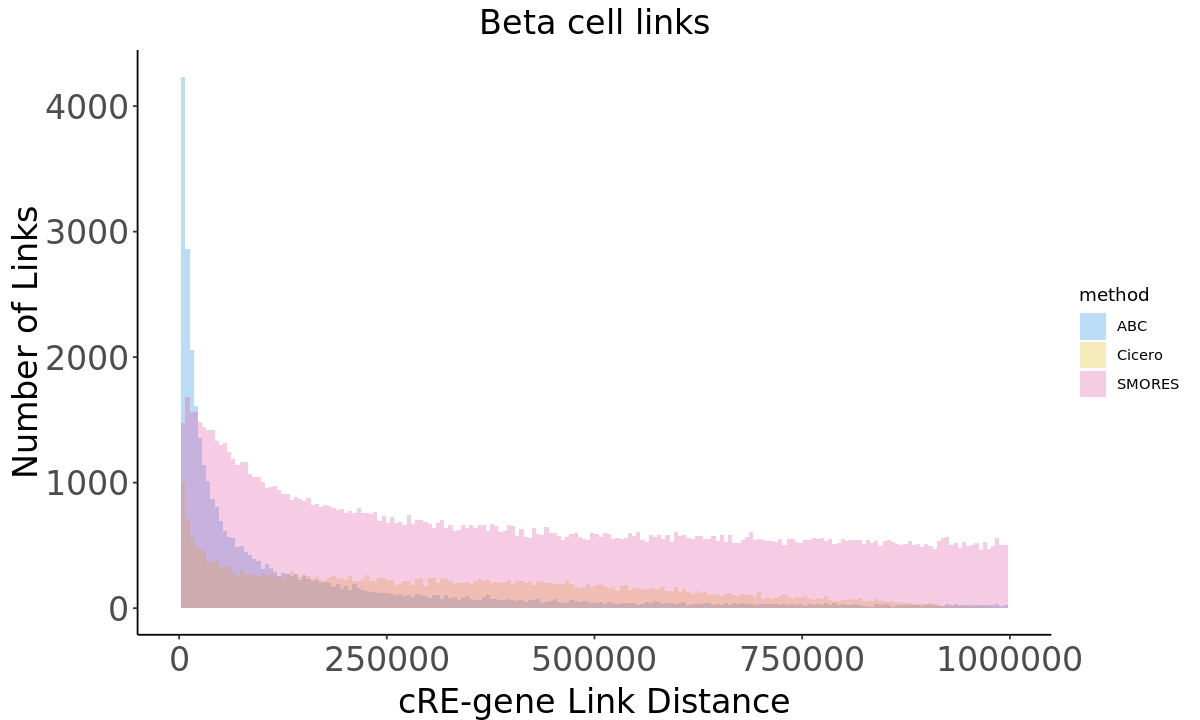

Warning message:
"Removed 3212 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


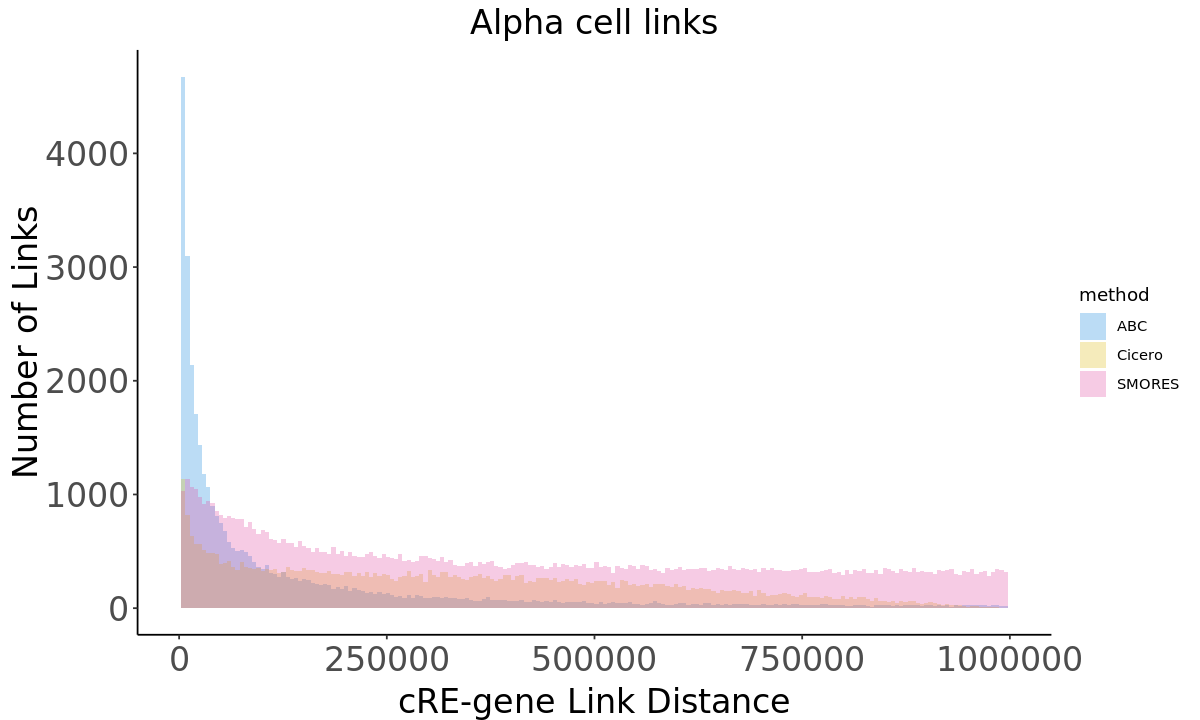

Warning message:
"Removed 3220 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


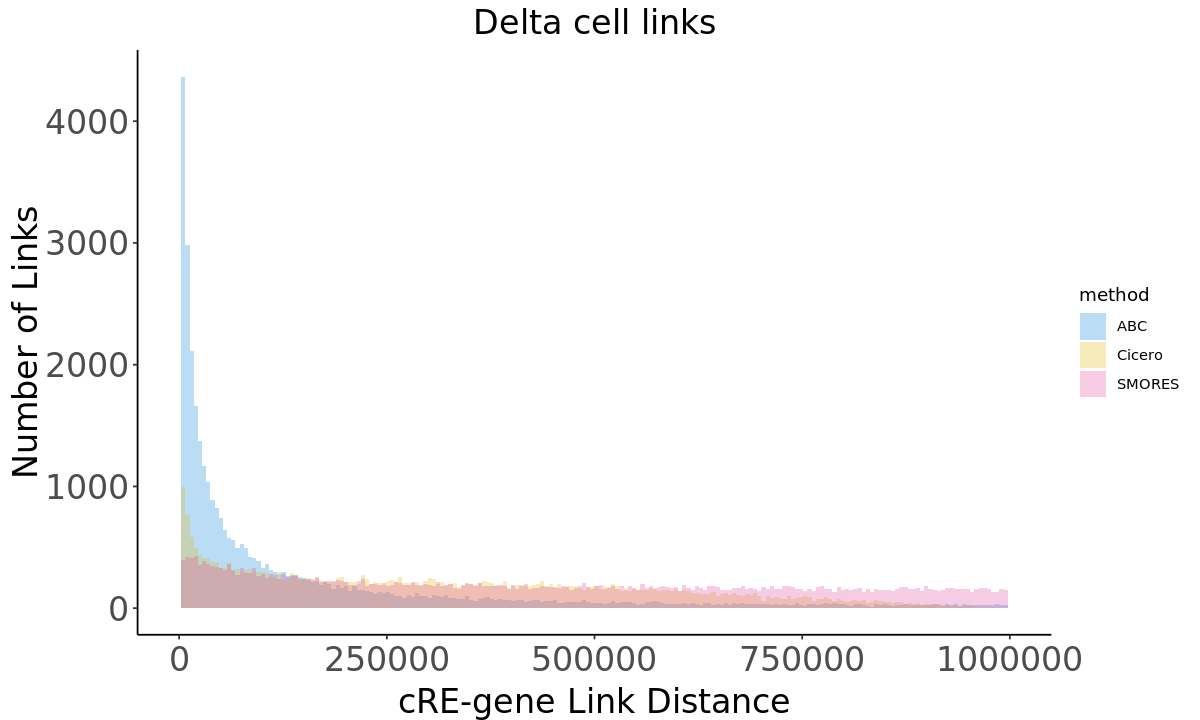

Warning message:
"Removed 4948 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


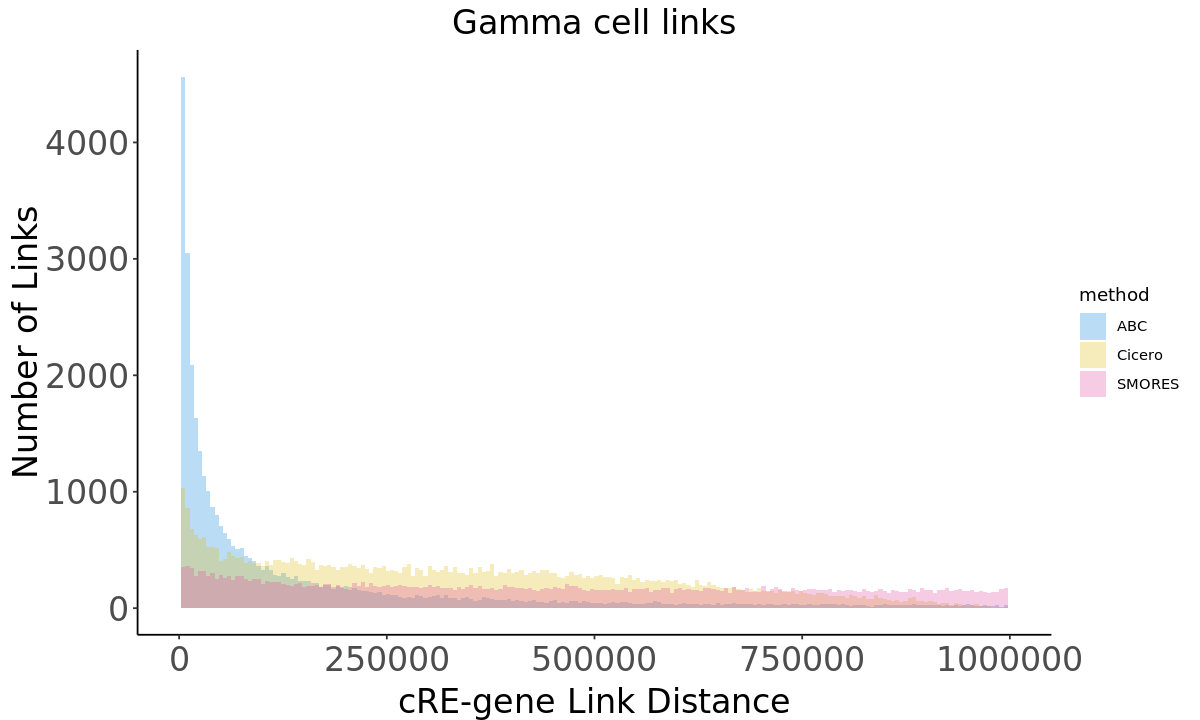

Warning message:
"Removed 3800 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


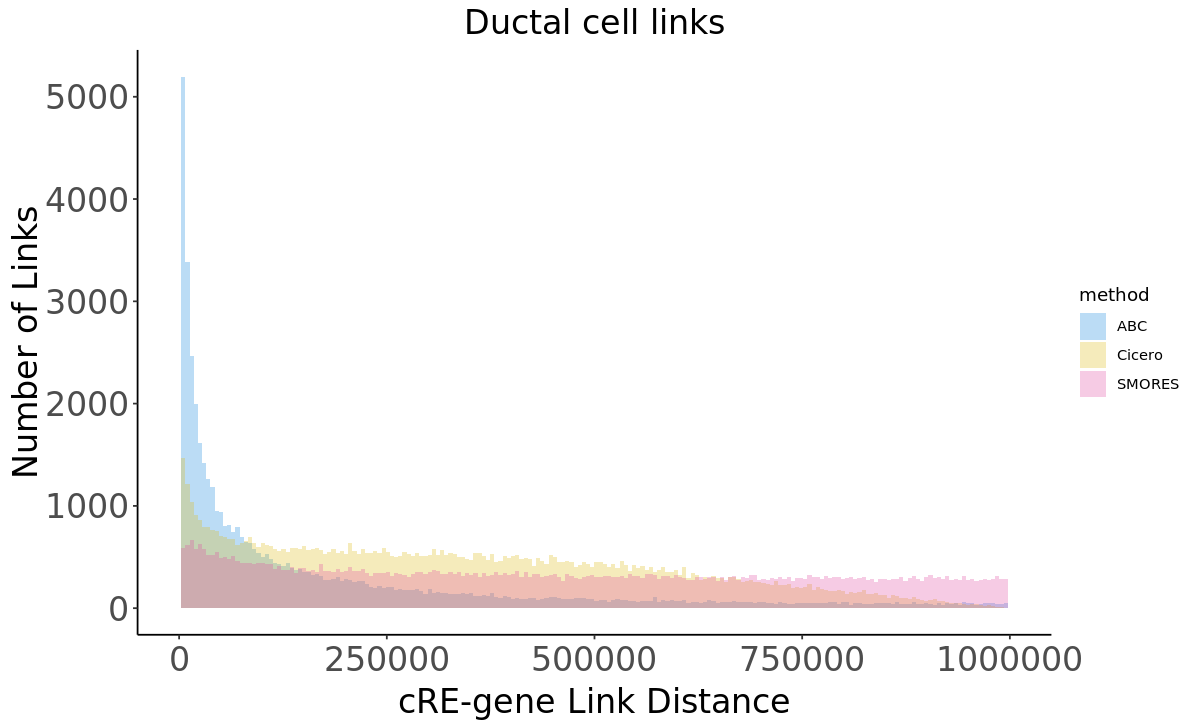

Warning message:
"Removed 3616 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


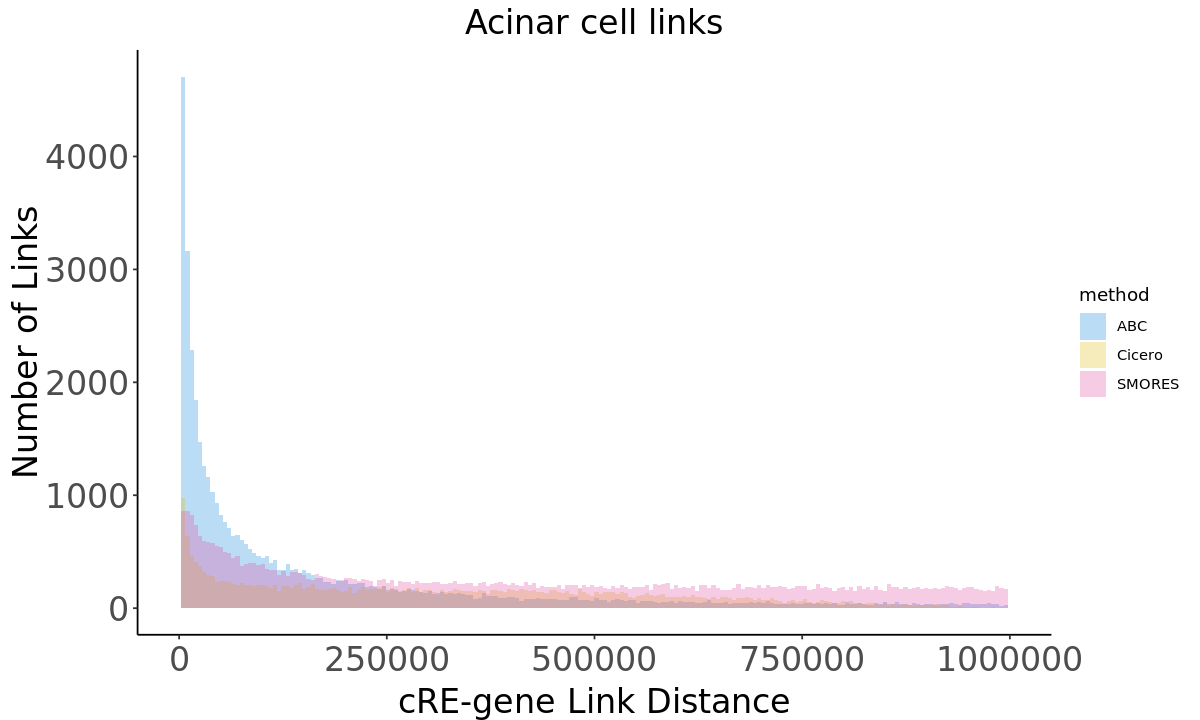

Warning message:
"Removed 5801 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


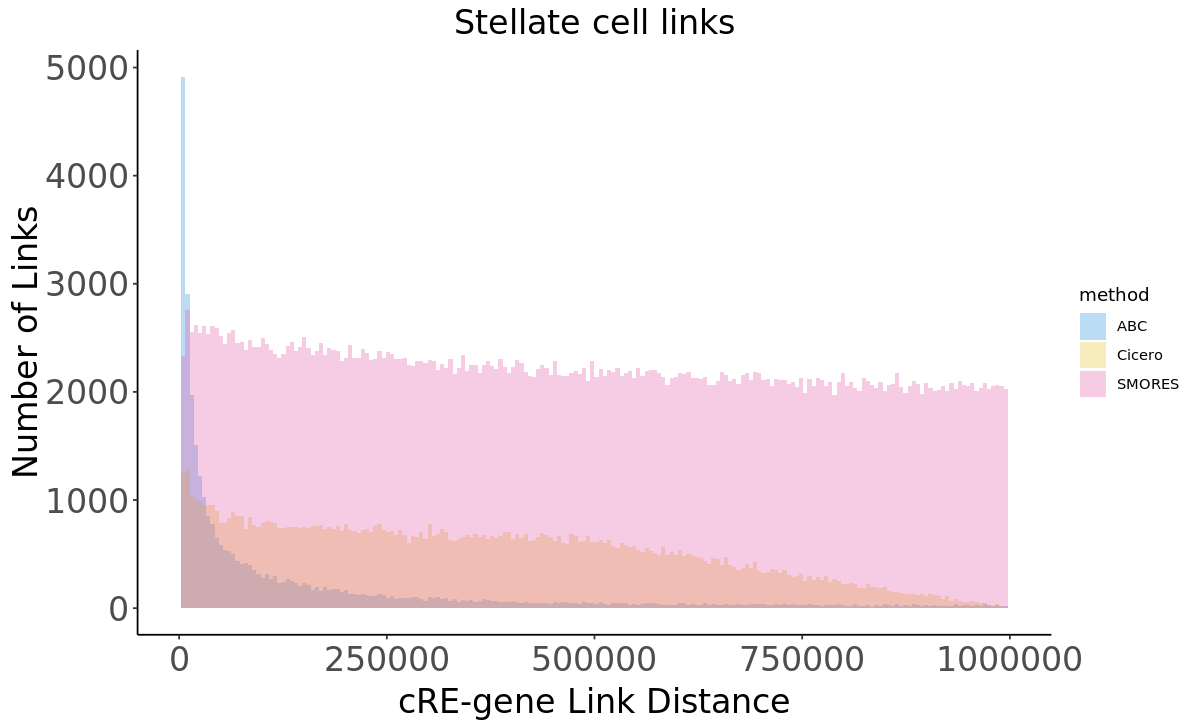

Warning message:
"Removed 6467 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


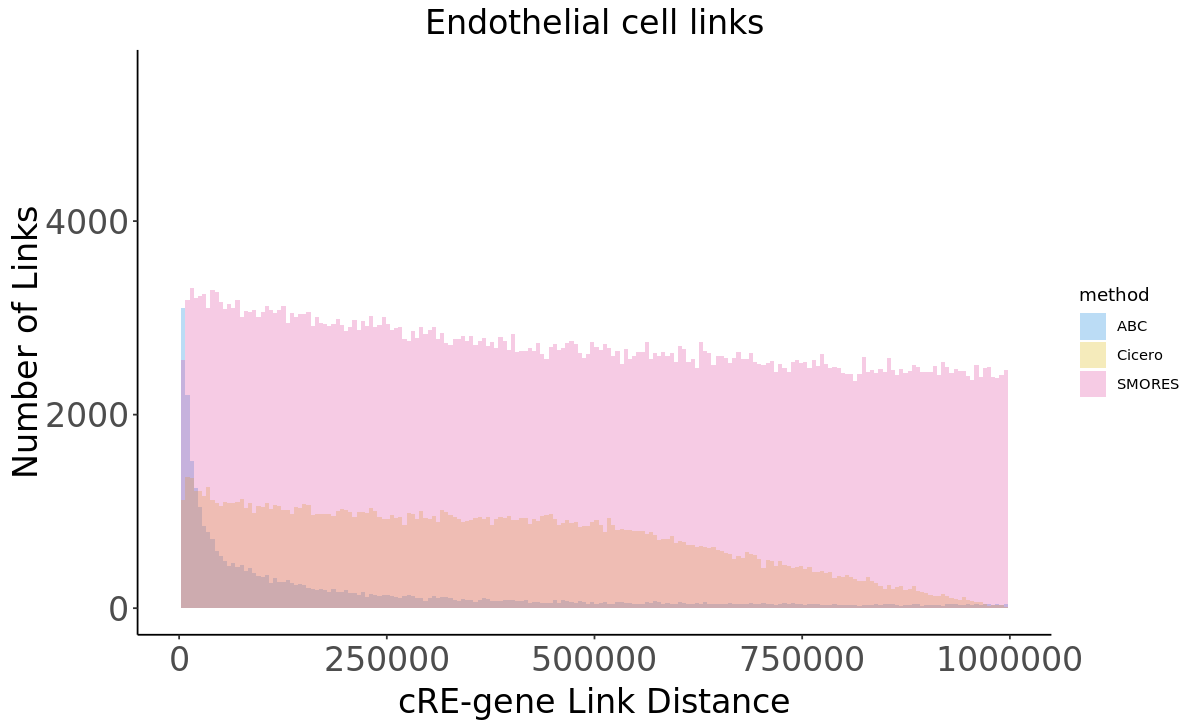

Warning message:
"Removed 4411 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


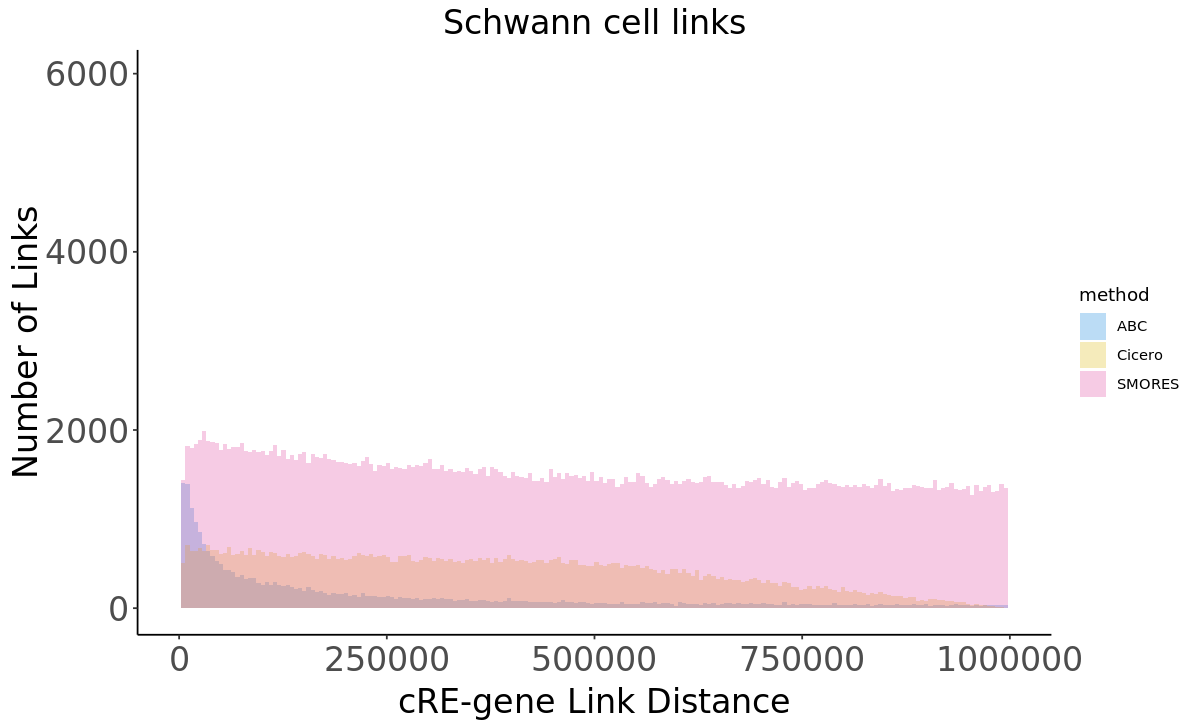

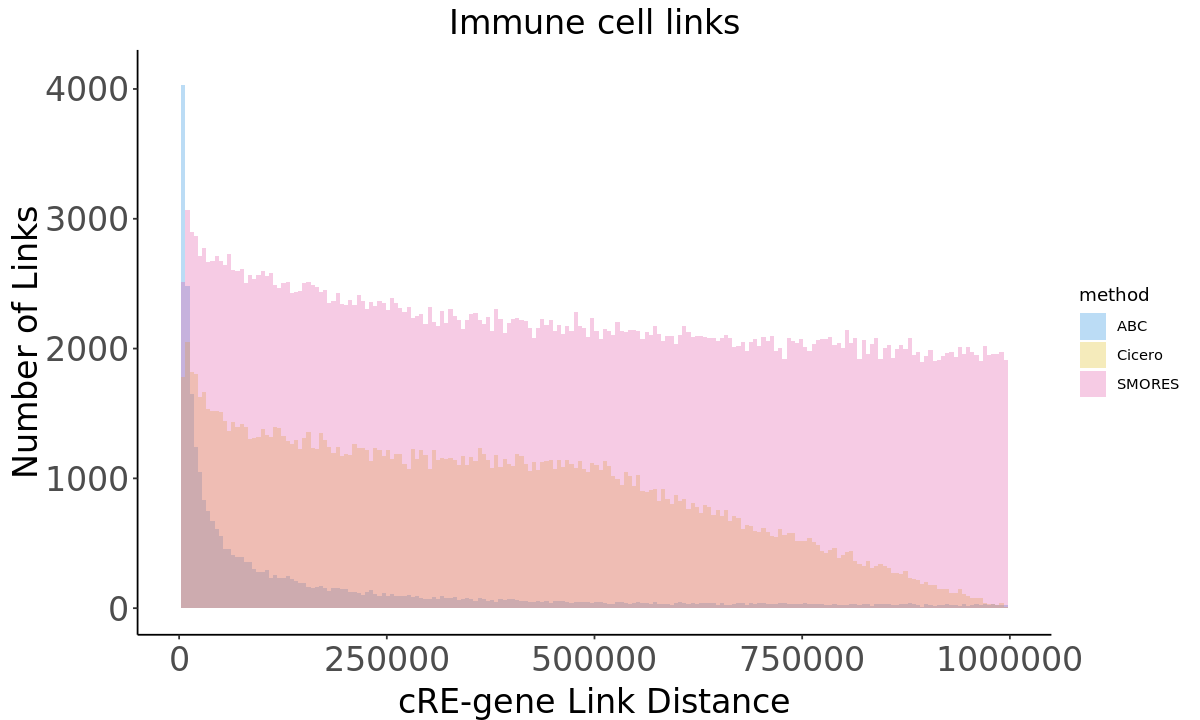

In [40]:
for (celltype in celltypes){
    smores_fp <- paste0(hm_prefix,celltype,'/',celltype,hm_suffix1)
    abc_fp <- file.path(abc_indir, sprintf('%s_mapped_links.bedpe',celltype))
    cic_fp <- file.path(cic_indir, sprintf('%s_links.CP_reformat.bedpe',celltype))
    compare_distance_distribs(celltype, smores_fp, abc_fp, cic_fp, method_colors,c(0,1000000))
}

Warning message:
"Removed 3110 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 2986 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


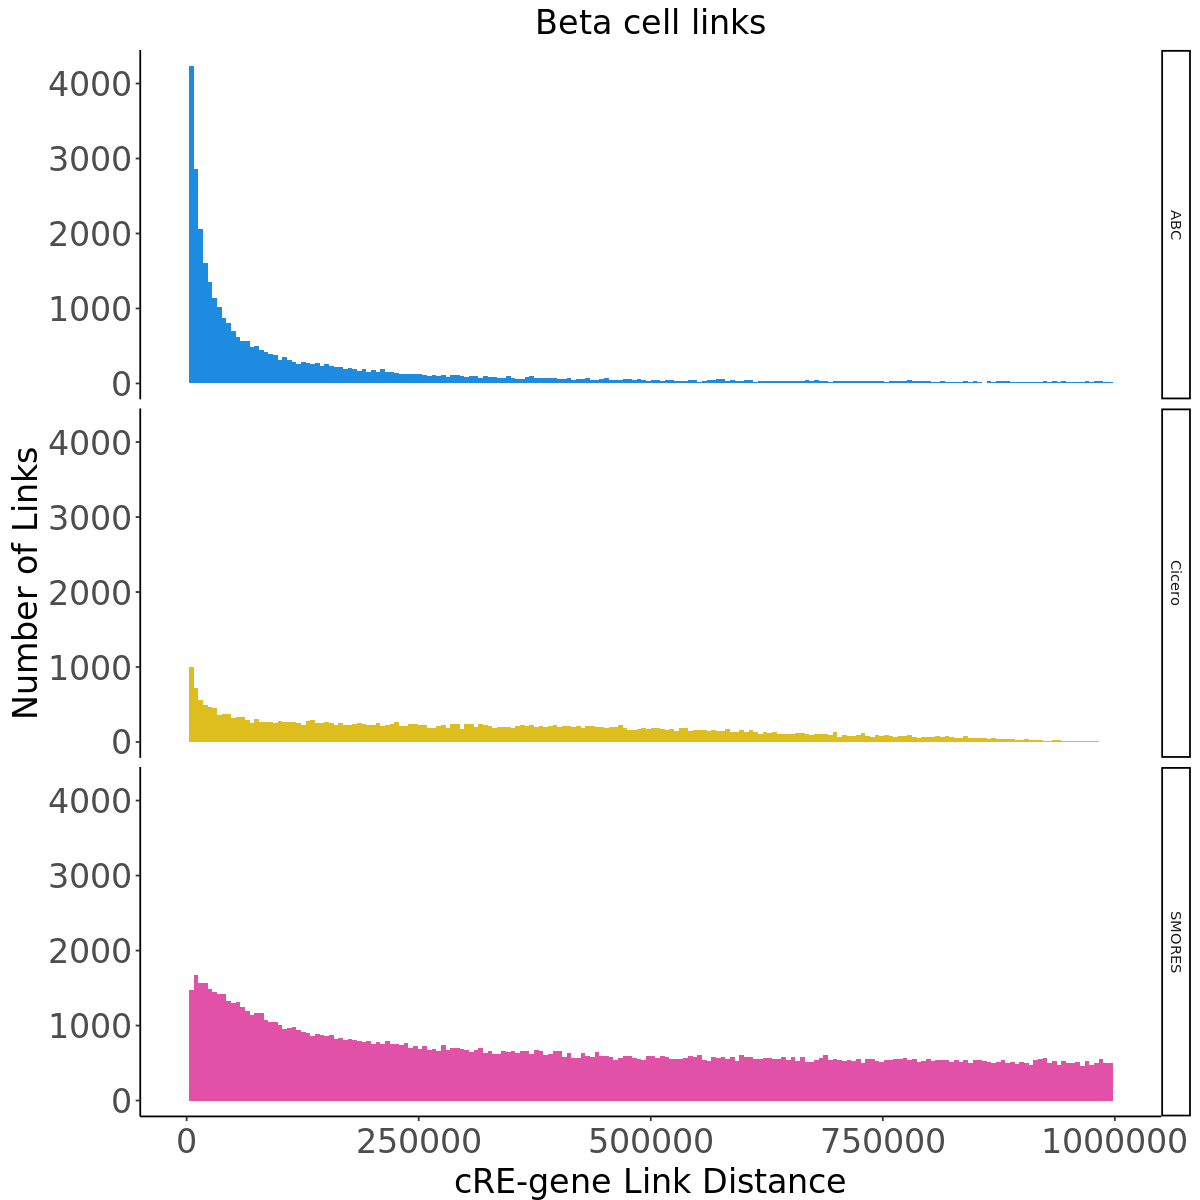

Warning message:
"Removed 3212 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


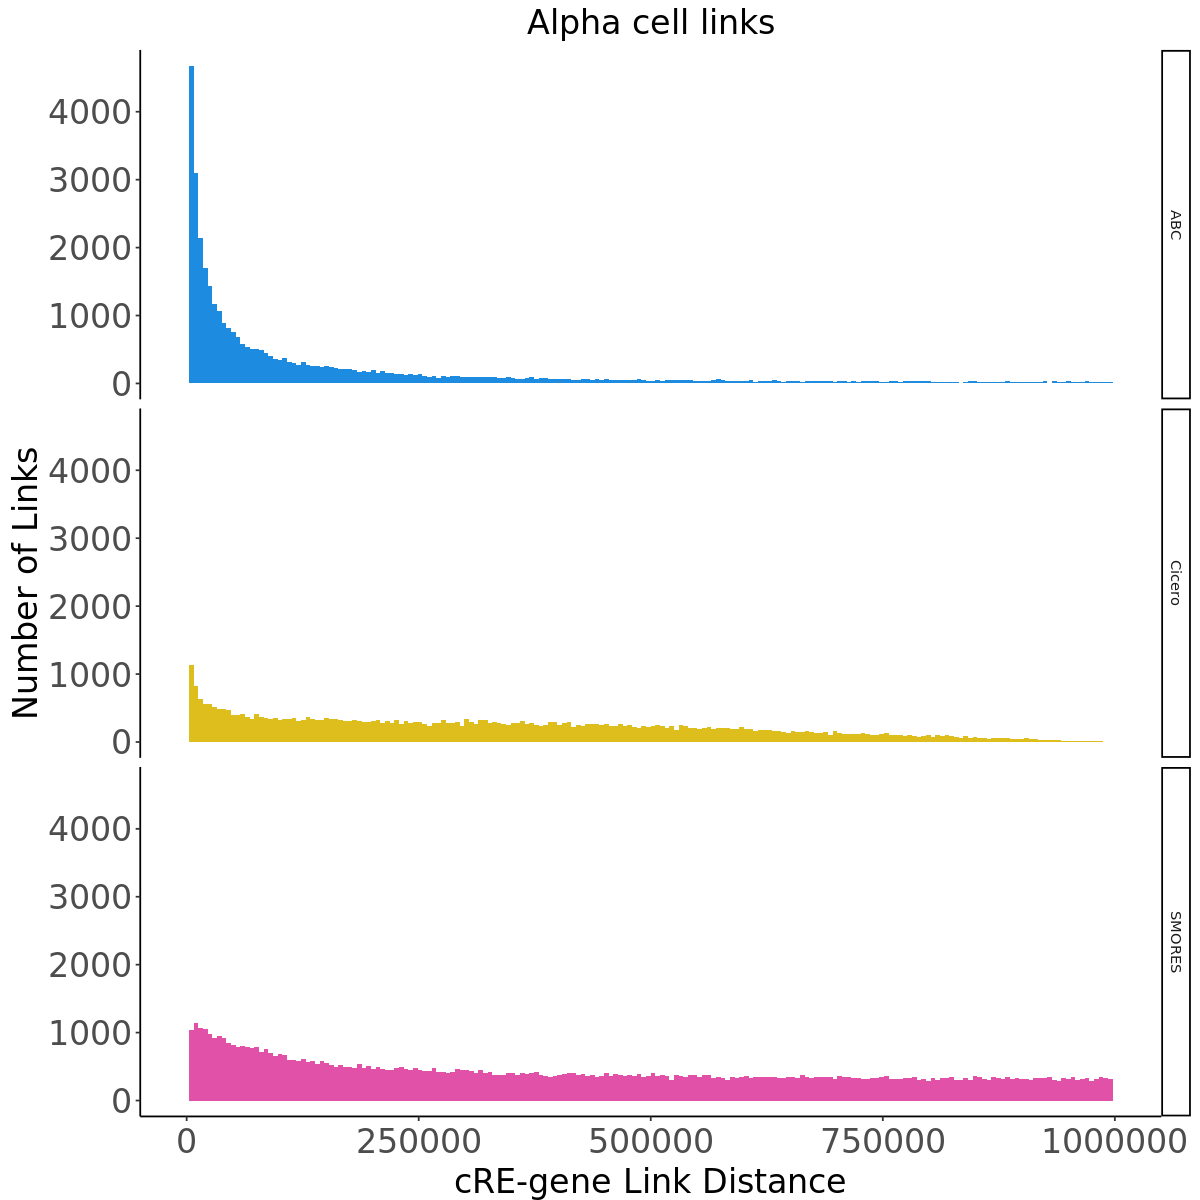

Warning message:
"Removed 3220 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


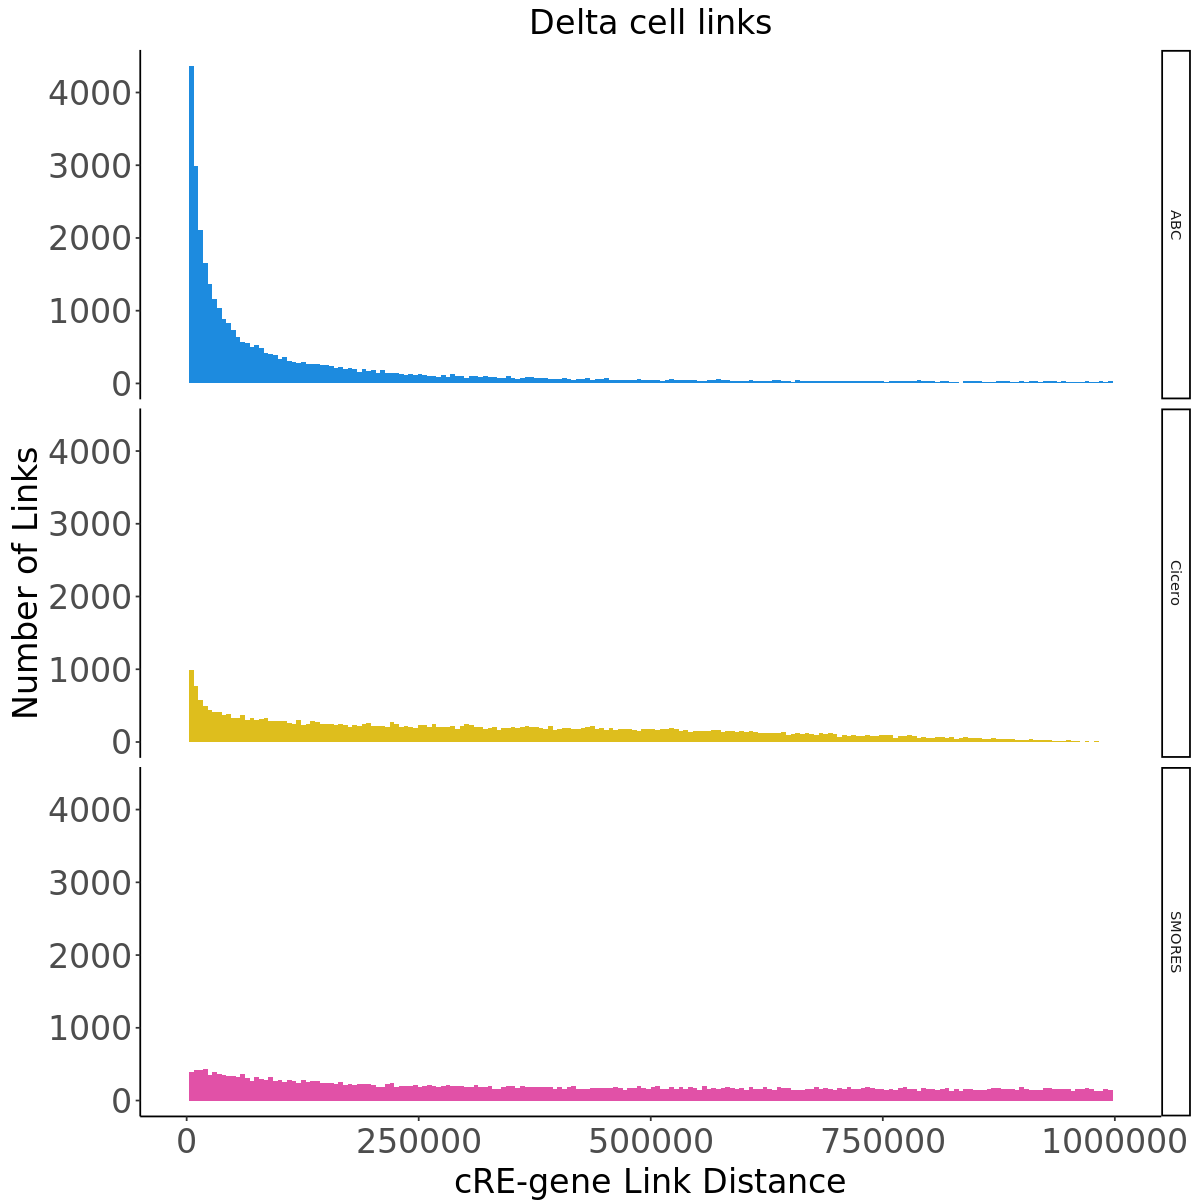

Warning message:
"Removed 4948 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


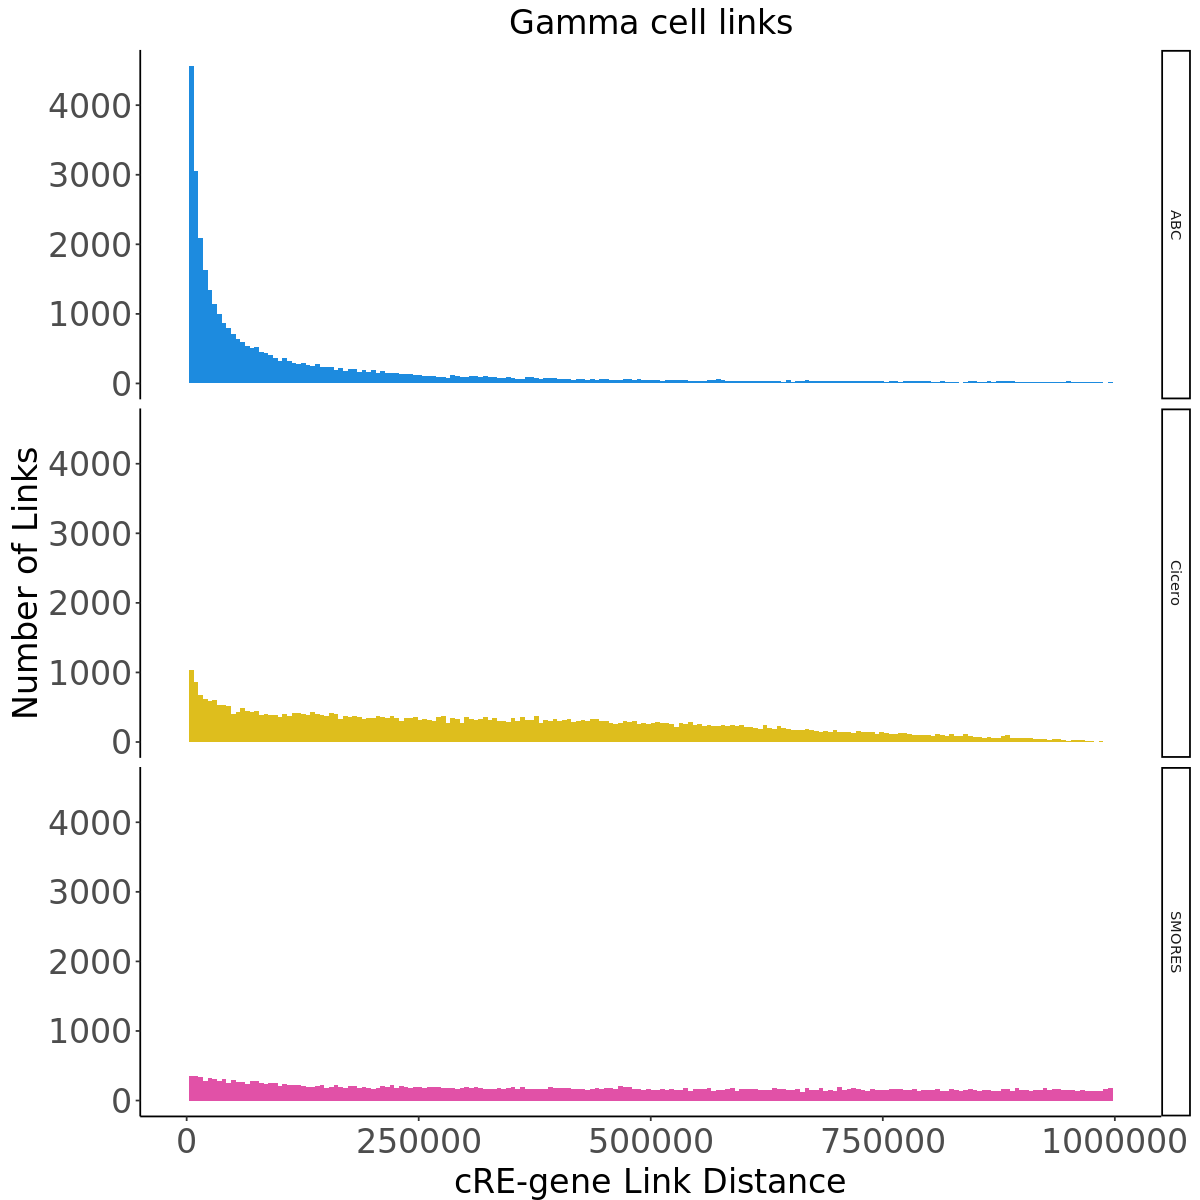

Warning message:
"Removed 3800 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


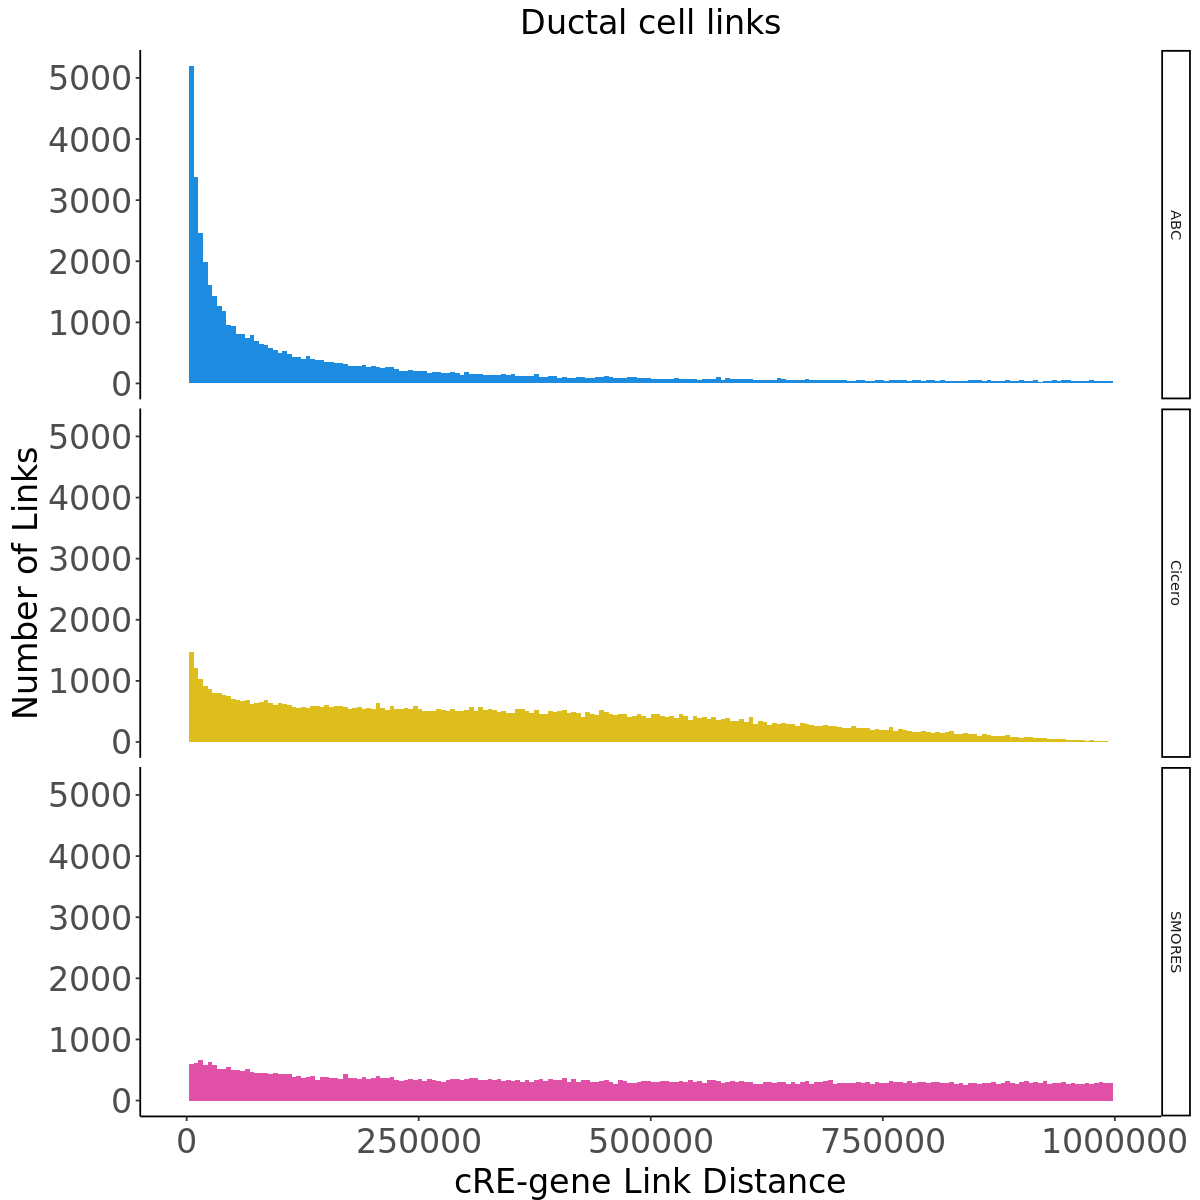

Warning message:
"Removed 3616 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


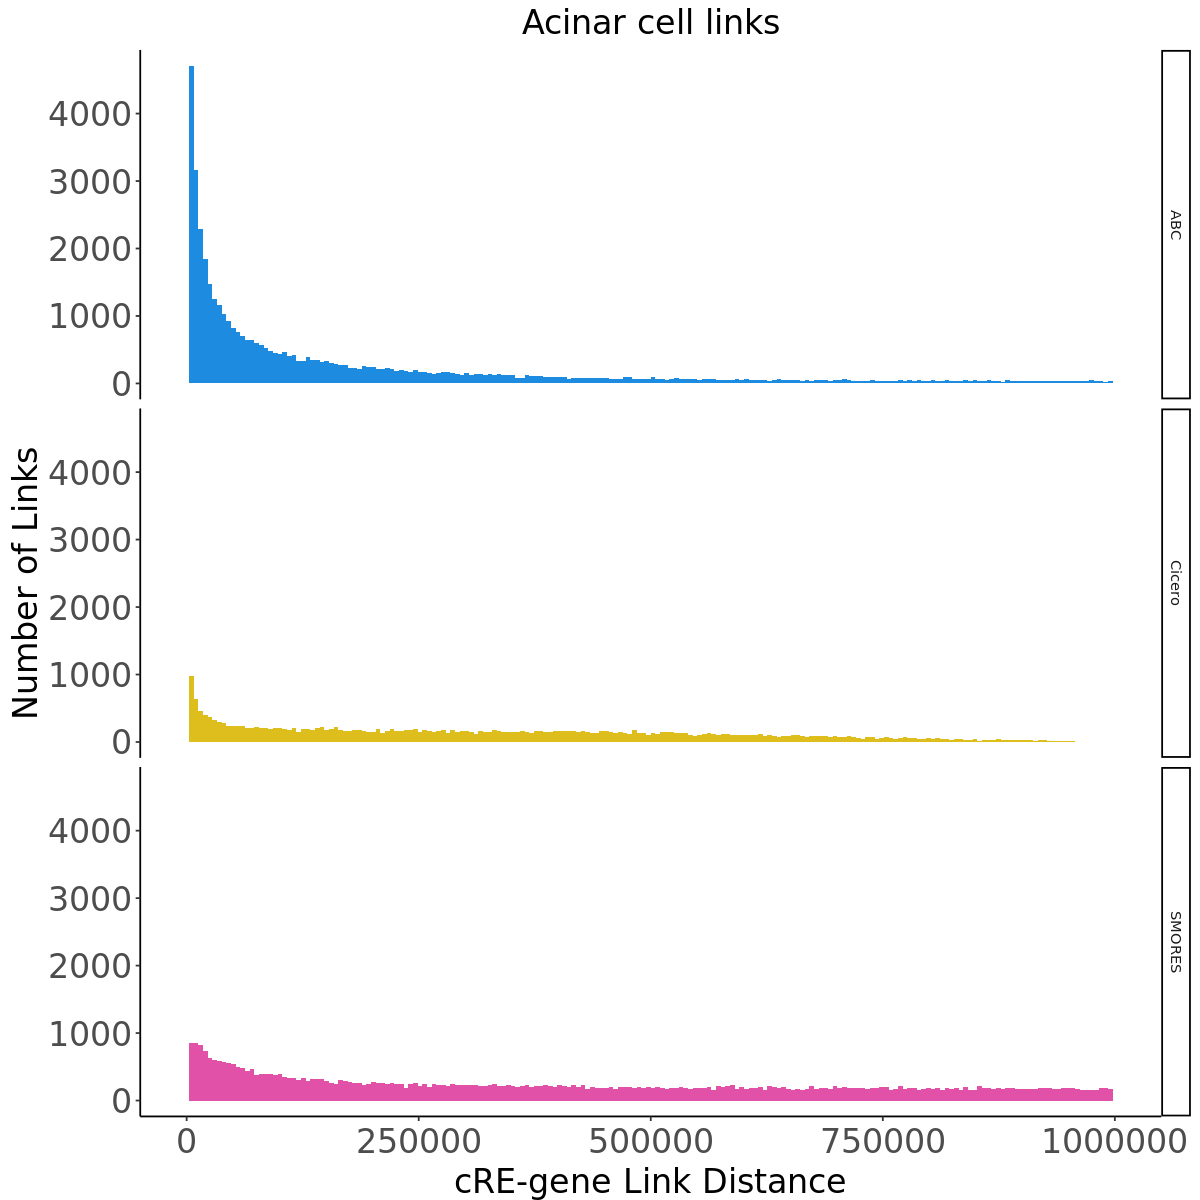

Warning message:
"Removed 5801 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


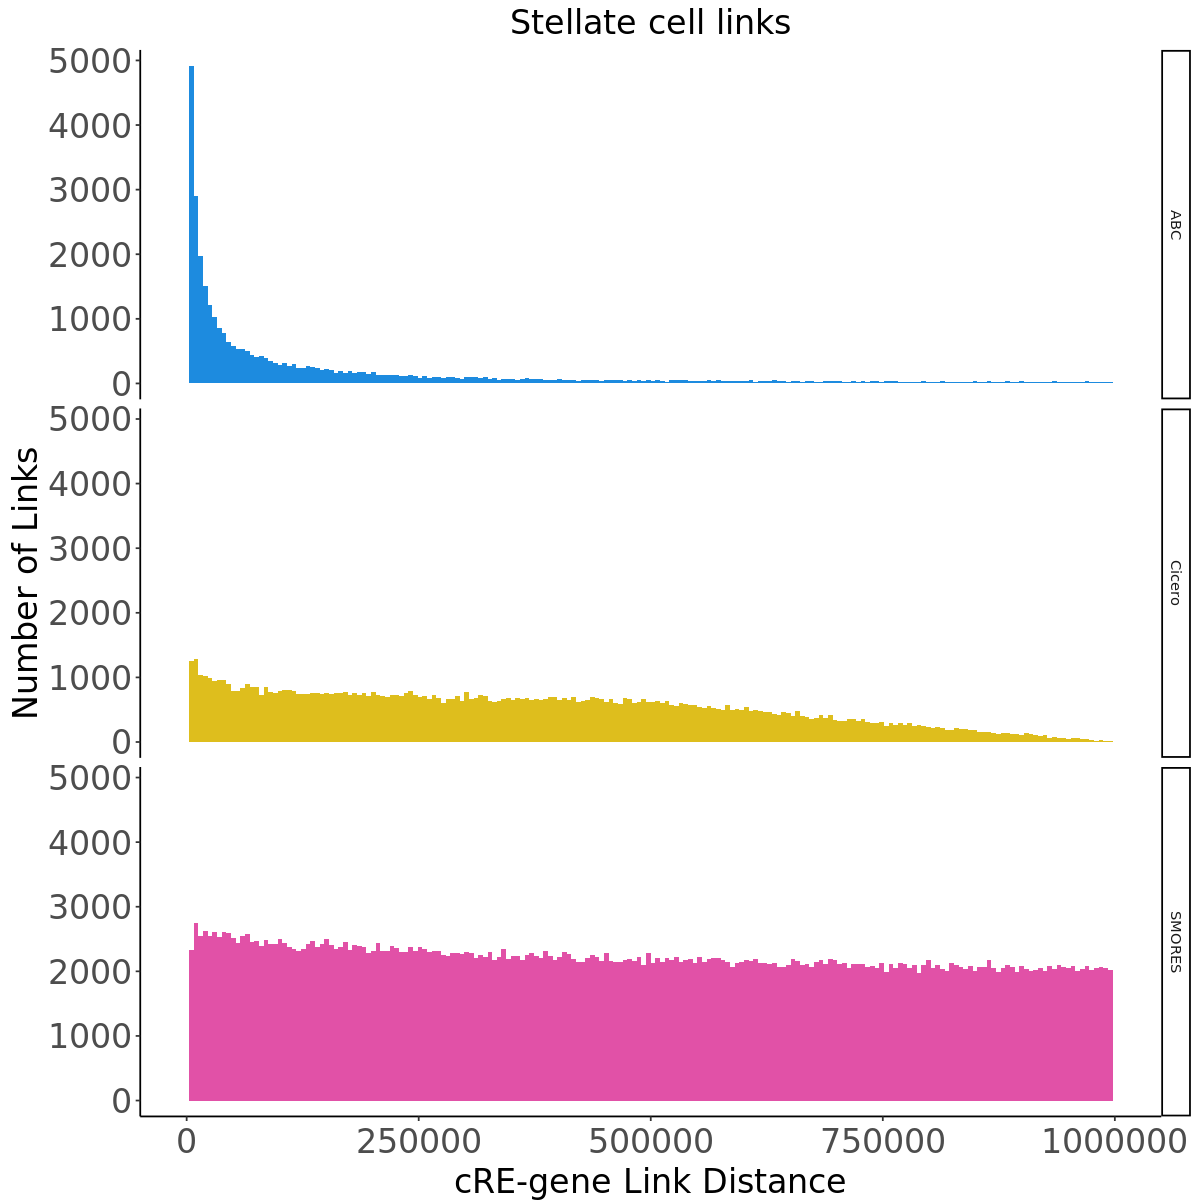

Warning message:
"Removed 6467 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


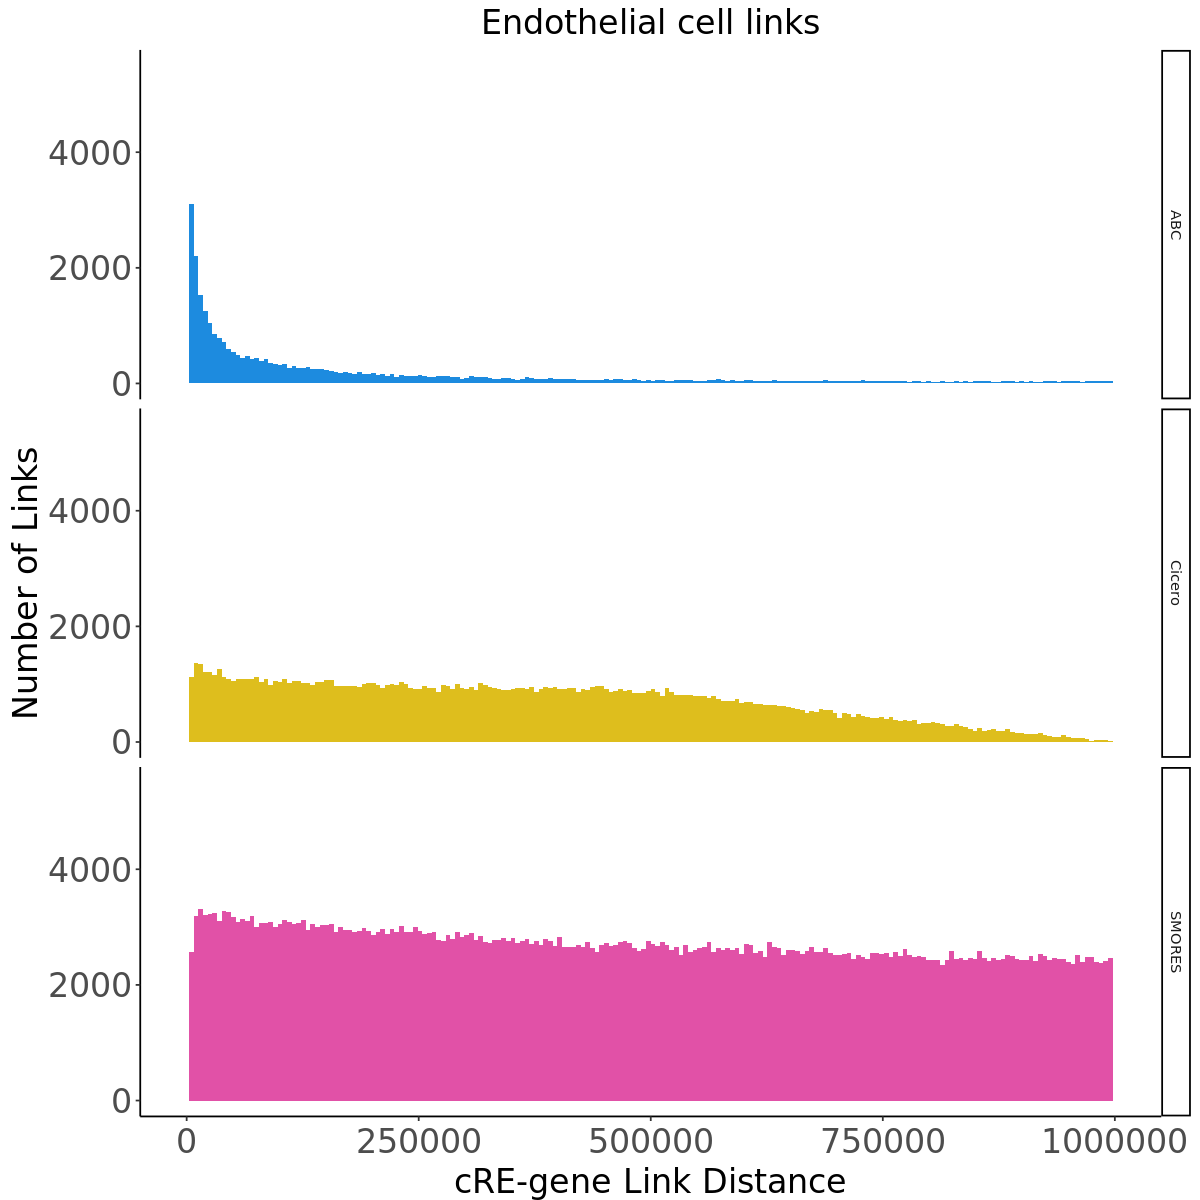

Warning message:
"Removed 4411 rows containing non-finite values (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values (`geom_bar()`)."


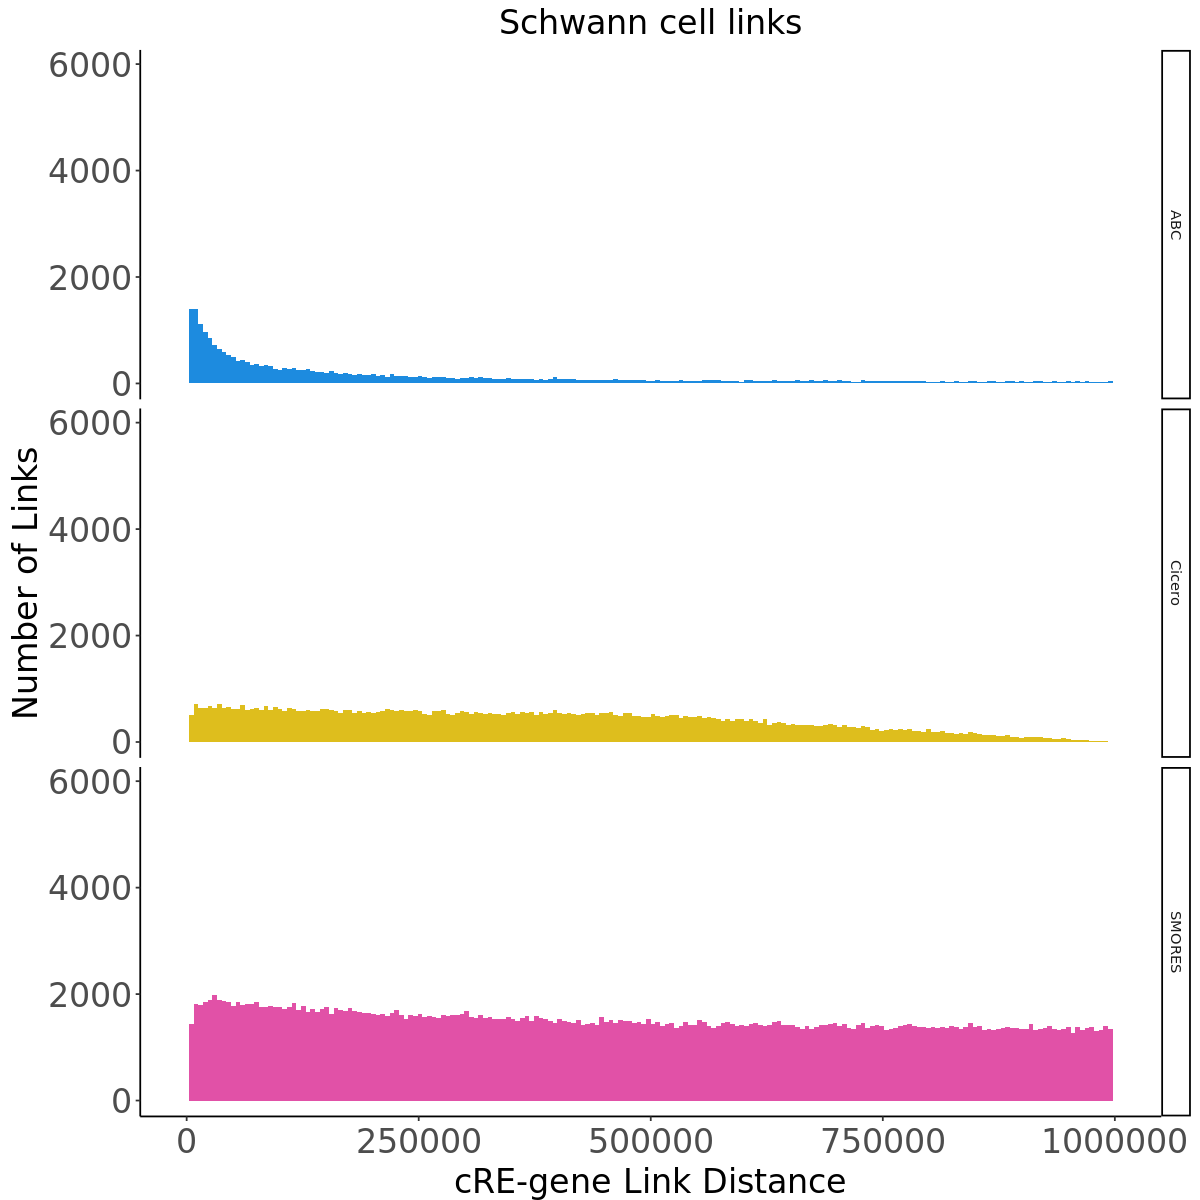

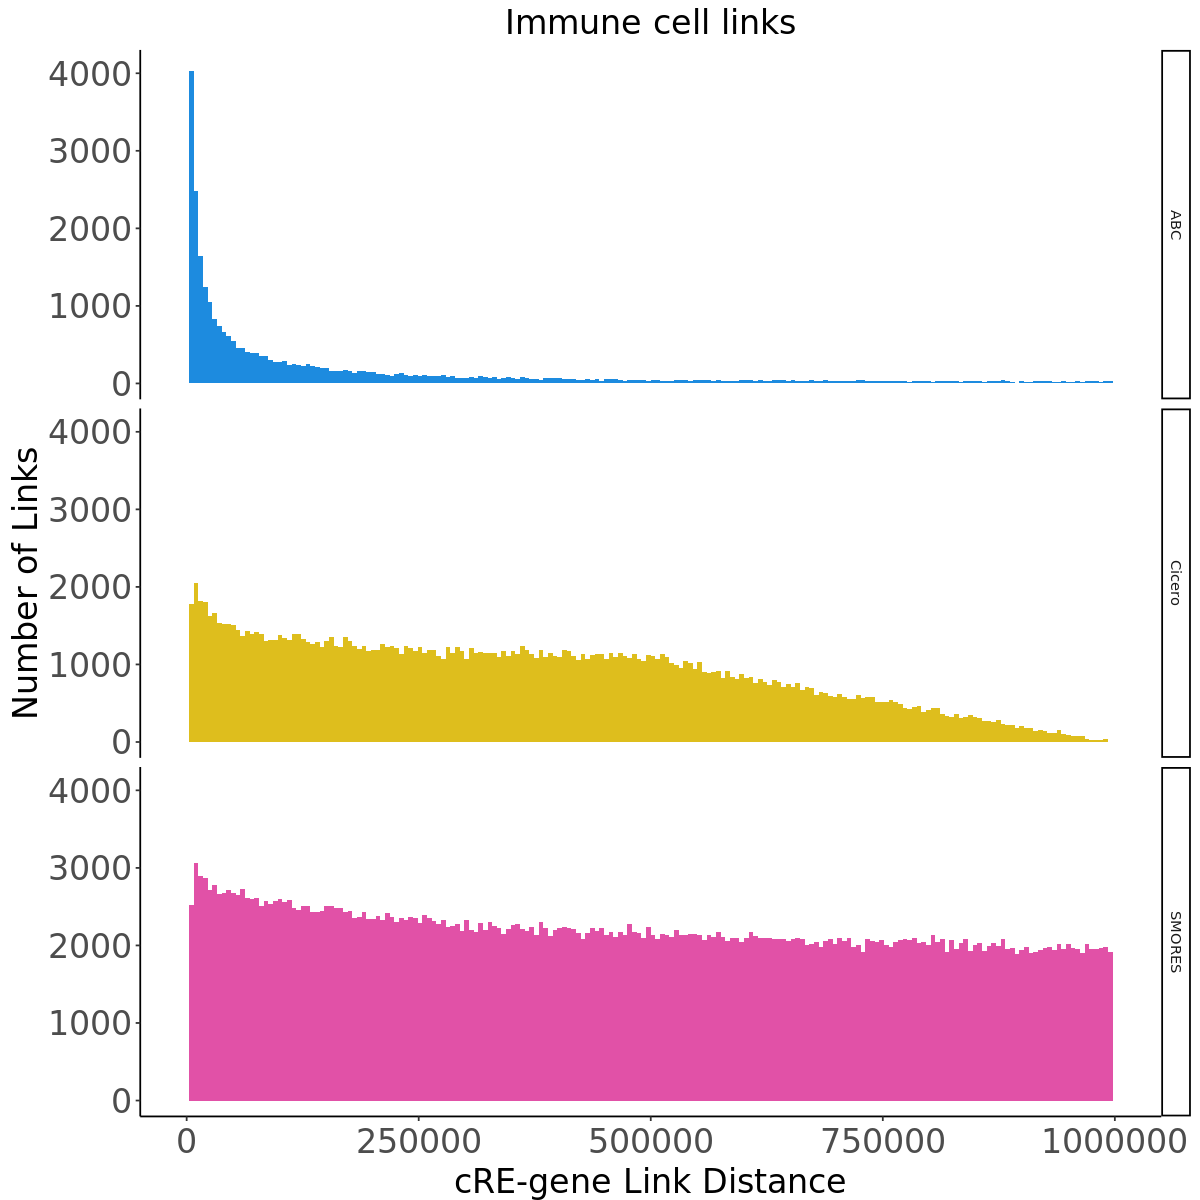

In [42]:
for (celltype in celltypes){
    smores_fp <- paste0(hm_prefix,celltype,'/',celltype,hm_suffix1)
    abc_fp <- file.path(abc_indir, sprintf('%s_mapped_links.bedpe',celltype))
    cic_fp <- file.path(cic_indir, sprintf('%s_links.CP_reformat.bedpe',celltype))
    compare_distance_distribs2(celltype, smores_fp, abc_fp, cic_fp, method_colors, c(0,1000000))
}

# 3a. Overlap Link Sets with Upset Plots
Overlaps links sets with Upset and make an upset plot. Then write files containing all links in each overlap combinations.

### Functions

In [9]:
### Function to process links into a common format list
get_formatted_links <- function(row){
    cre = paste(row[[1]],row[[2]],row[[3]],sep='-')
    gene = row[[7]]
    return(paste(cre,gene,sep="_"))
}

In [10]:
### Function to compare the celltype links from 3 methods using an Upset plot
compare_links_plots <- function(celltype, colors){
    # Set up file paths for each links set
    #hm_fp <- paste0(hm_prefix, celltype, '/', celltype, hm_suffix1)
    hm_fp <- paste0(hm_prefix, celltype, hm_suffix1)
    abc_fp <- file.path(abc_indir, sprintf('%s_mapped_links.bedpe',celltype))
    cic_fp <- file.path(cic_indir, sprintf('%s_links.CP_reformat.bedpe',celltype))
    
    # Read in links and convert to basic format
    hm_df <- read.table(hm_fp, sep='\t')
    hm_links <- gsub(" ","",apply(hm_df, 1, get_formatted_links))
    print(paste0('Total number of HM links: ', length(hm_links)))
    abc_df <- read.table(abc_fp, sep='\t')
    abc_links <- gsub(" ","",apply(abc_df, 1, get_formatted_links))
    print(paste0('Total number of ABC links: ', length(abc_links)))
    cic_df <- read.table(cic_fp, sep='\t')
    cic_links <- gsub(" ","",apply(cic_df, 1, get_formatted_links))
    print(paste0('Total number of Cicero links: ', length(cic_links)))
    
    # Make Upset plot object
    listInput <- list(smores = hm_links, abc = abc_links, cic=cic_links)
    options(repr.plot.width = 12, repr.plot.height = 8)
    p1 <- upset(fromList(listInput), order.by = "degree", sets.x.label="Links datasets",
                text.scale=c(1.5,1.5,1.5,1.5,2,2), point.size=5, line.size=2, main.bar.color=colors)     
    print(p1)
    title <- sprintf('%s links overlaps',celltype)
    grid.text(title, x=0.6, y=0.95, gp=gpar(fontsize=20))
}

### Run functions to overlap cRE-gene links sets and make outputs

In [12]:
black_colors <- rep('#000000', 7)
colors <- c('#000000', #All 3 links (black)
            '#7EA57E', #ABC + Cicero (green)
            '#E08862', #HM + Cicero (purple)
            '#7F6EC3', #HM + ABC (orange)
            '#DEBE1D', #Cicero (yellow)
            '#1D8BDF', #ABC (blue)
            '#E151A7') #HM (pink)

[1] "beta 2023-03-15 13:33:03"
[1] "Total number of HM links: 139114"
[1] "Total number of ABC links: 39306"
[1] "Total number of Cicero links: 34789"
[1] "alpha 2023-03-15 13:33:46"
[1] "Total number of HM links: 87539"
[1] "Total number of ABC links: 40883"
[1] "Total number of Cicero links: 44644"


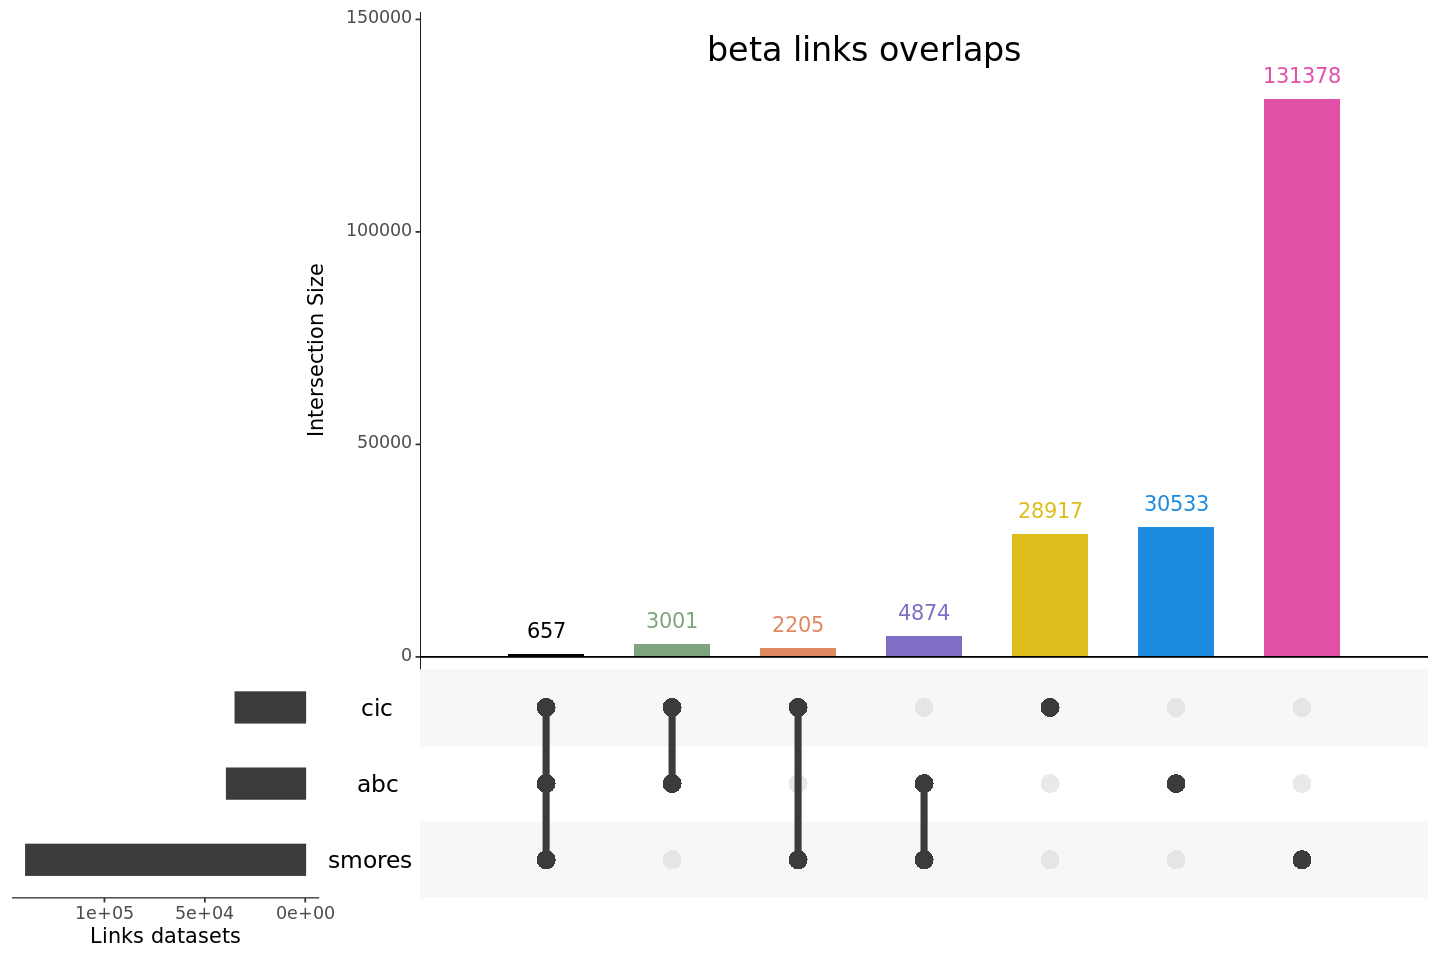

[1] "delta 2023-03-15 13:34:19"
[1] "Total number of HM links: 39681"
[1] "Total number of ABC links: 40612"
[1] "Total number of Cicero links: 34556"


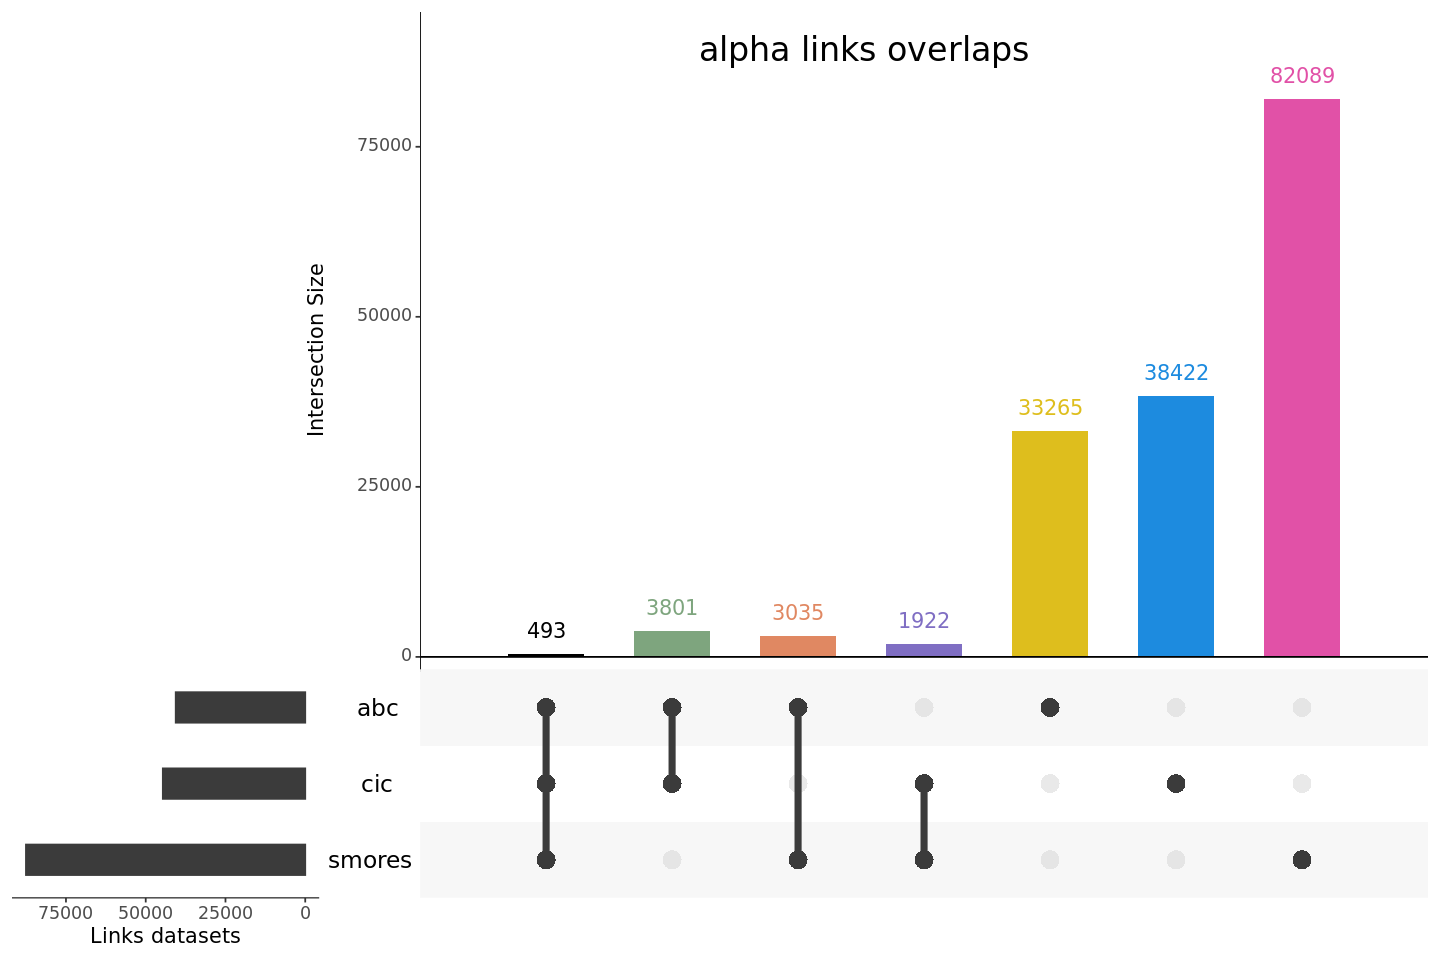

[1] "gamma 2023-03-15 13:34:44"
[1] "Total number of HM links: 36361"
[1] "Total number of ABC links: 40763"
[1] "Total number of Cicero links: 51066"


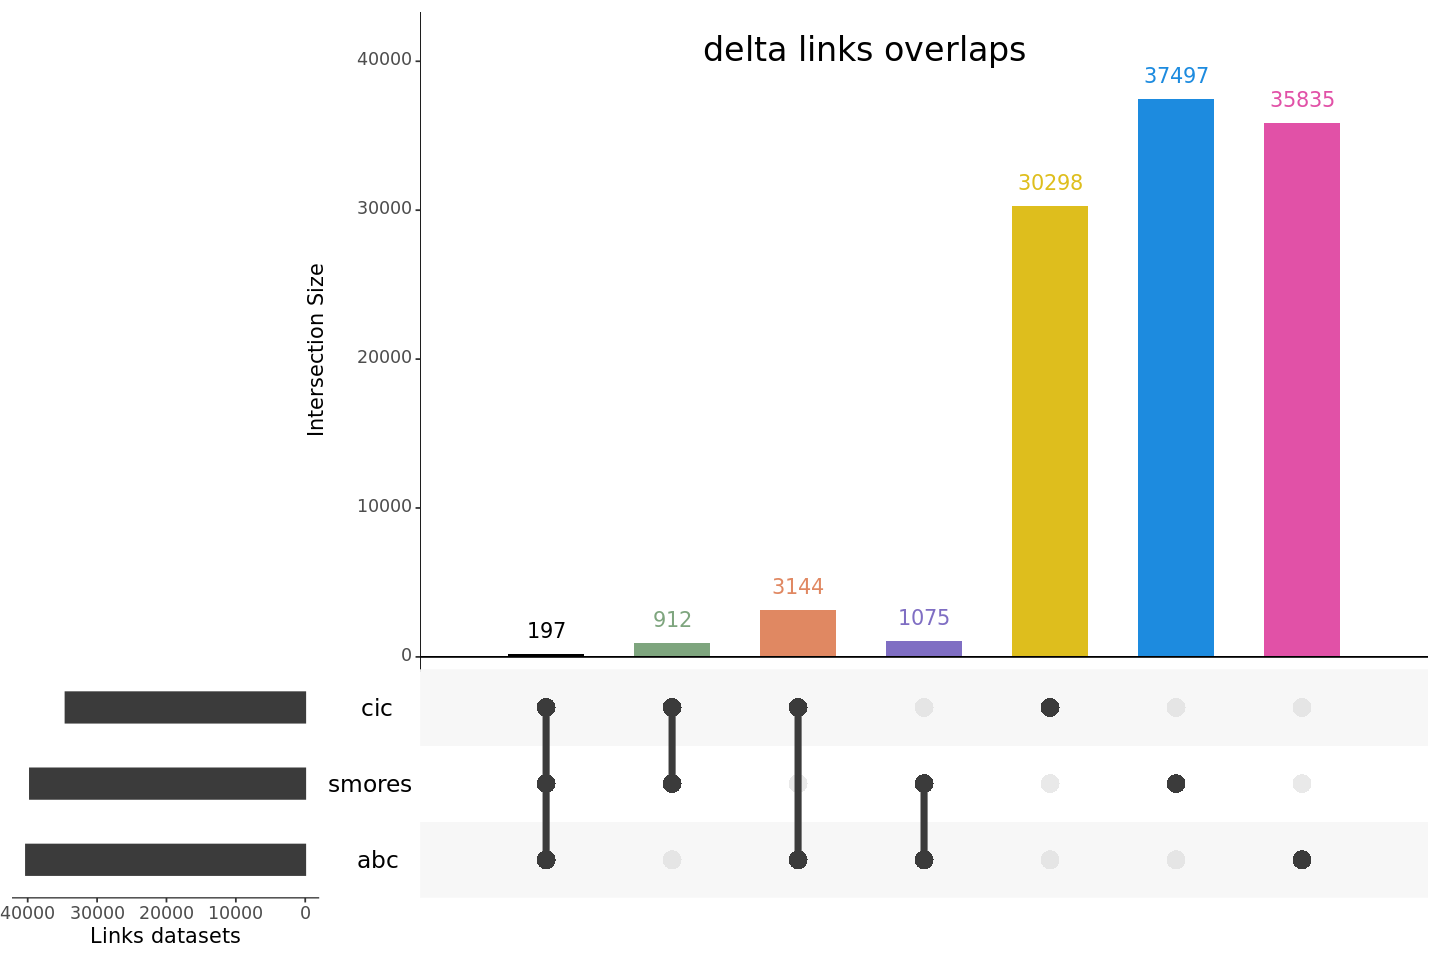

[1] "ductal 2023-03-15 13:35:08"
[1] "Total number of HM links: 68026"
[1] "Total number of ABC links: 56454"
[1] "Total number of Cicero links: 79465"


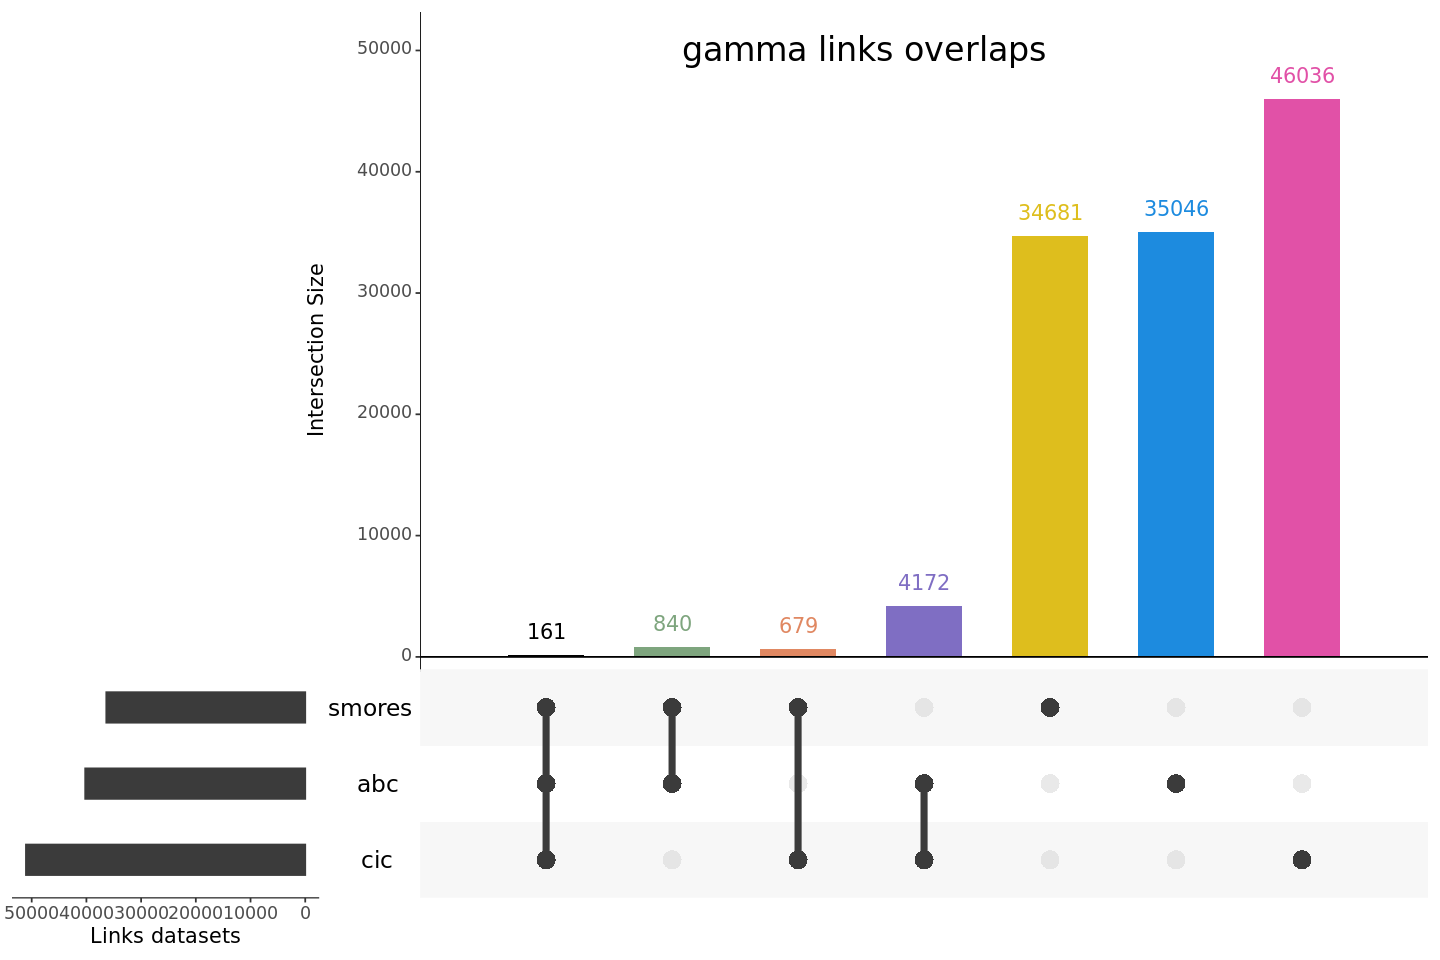

[1] "acinar 2023-03-15 13:35:58"
[1] "Total number of HM links: 49552"
[1] "Total number of ABC links: 48776"
[1] "Total number of Cicero links: 26658"


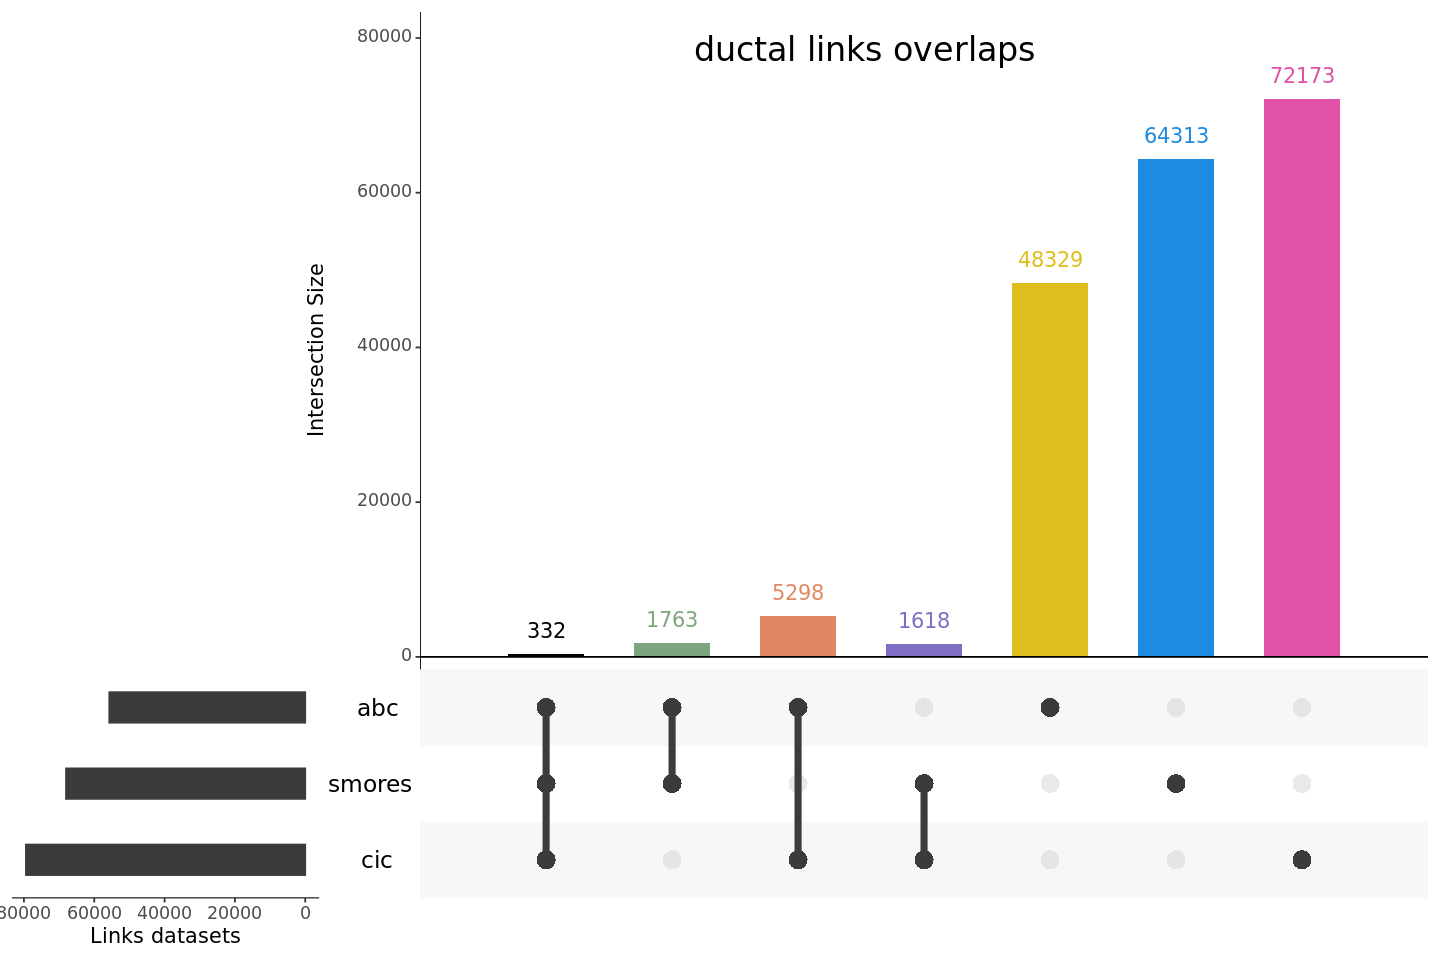

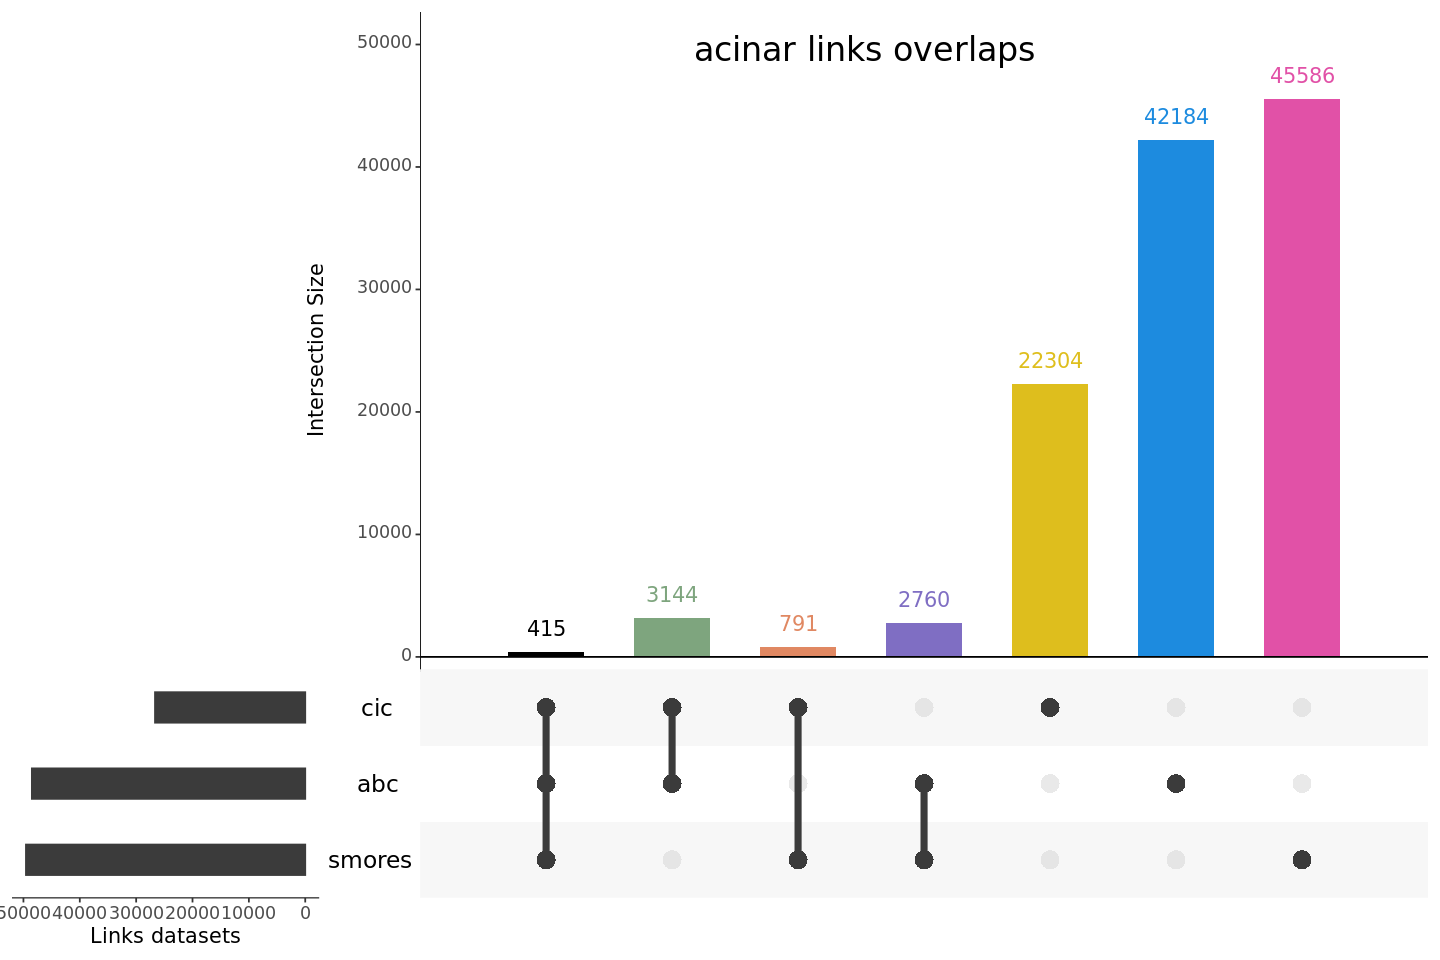

In [11]:
for (celltype in celltypes[seq(6)]){
    print(paste(celltype, Sys.time()))
    compare_links_plots(celltype, colors)
}

[1] "Total number of HM links: 139114"
[1] "Total number of ABC links: 39306"
[1] "Total number of Cicero links: 34789"
249.404 sec elapsed
[1] "Total number of HM links: 87539"
[1] "Total number of ABC links: 40883"
[1] "Total number of Cicero links: 44644"
249.633 sec elapsed


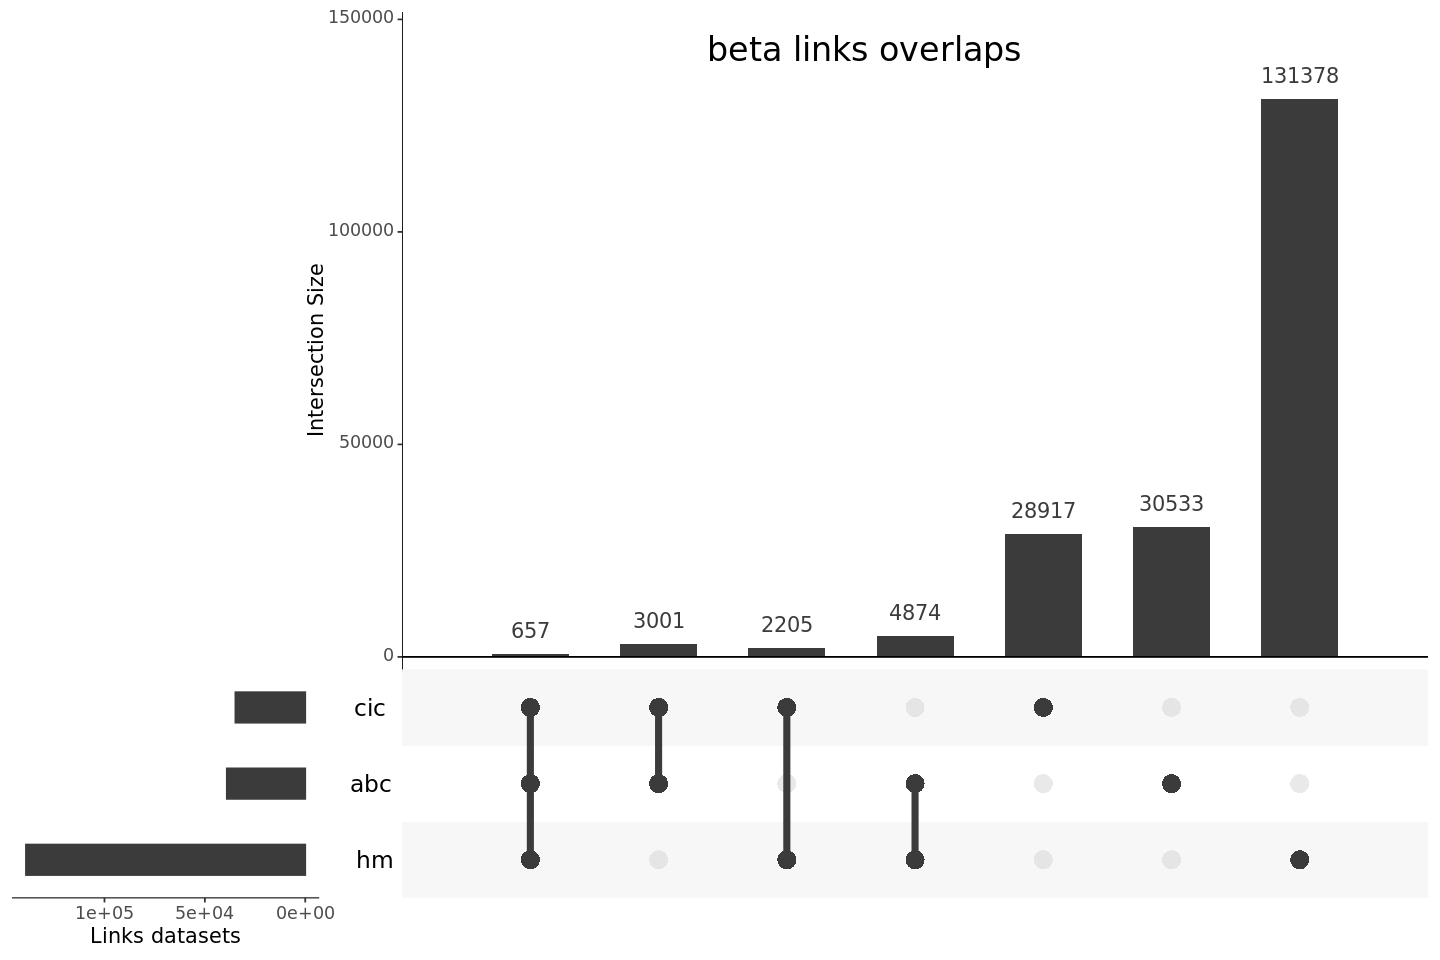

[1] "Total number of HM links: 39681"
[1] "Total number of ABC links: 40612"
[1] "Total number of Cicero links: 34556"
230.836 sec elapsed


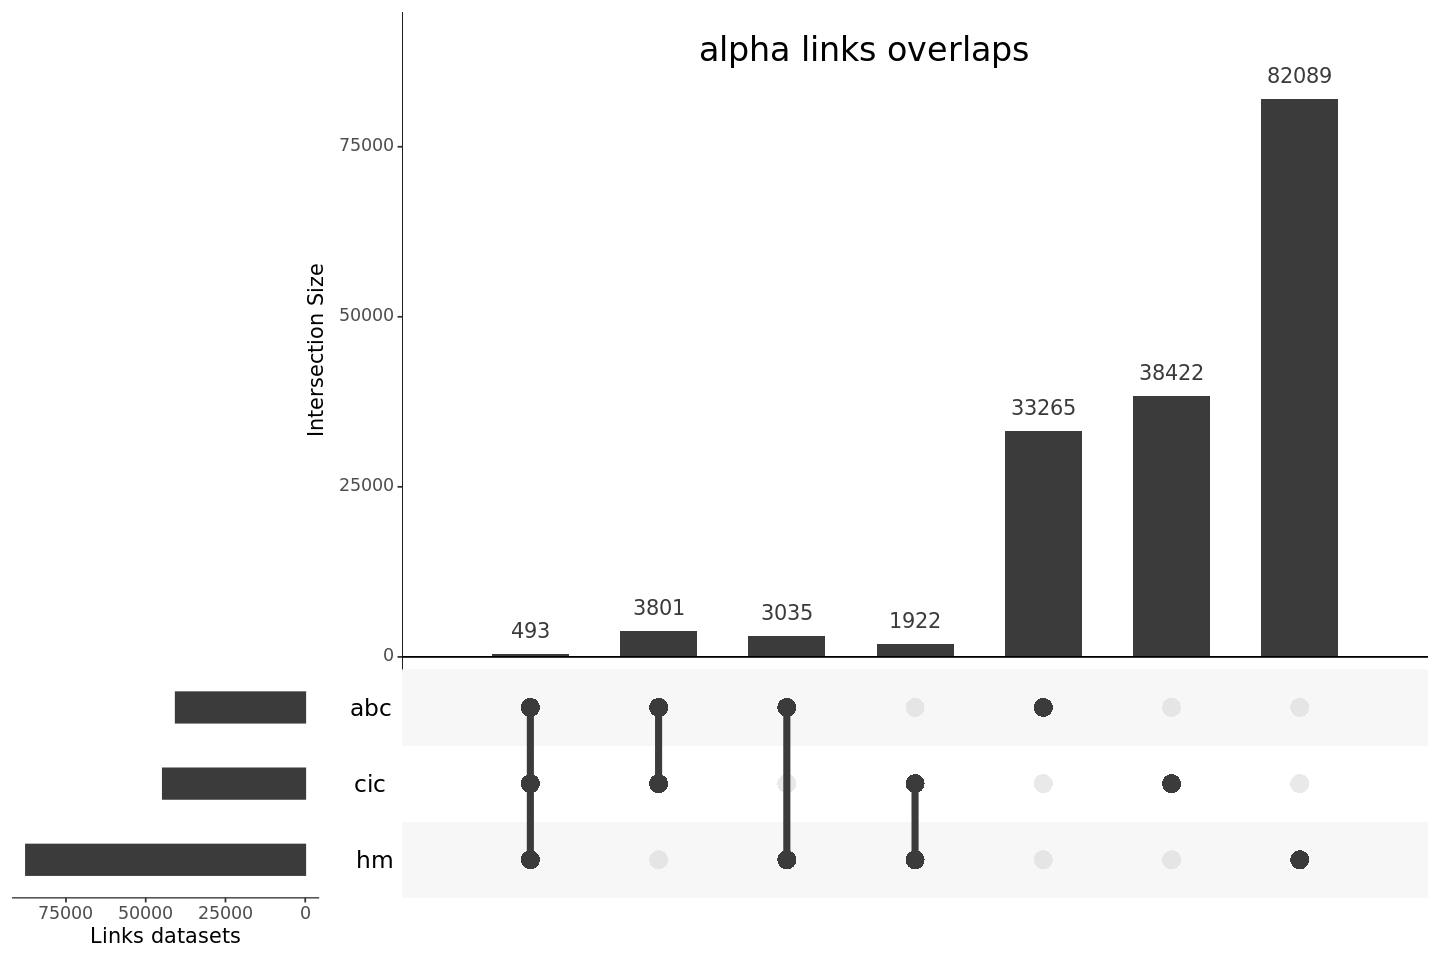

[1] "Total number of HM links: 36361"
[1] "Total number of ABC links: 40763"
[1] "Total number of Cicero links: 51066"
228.769 sec elapsed


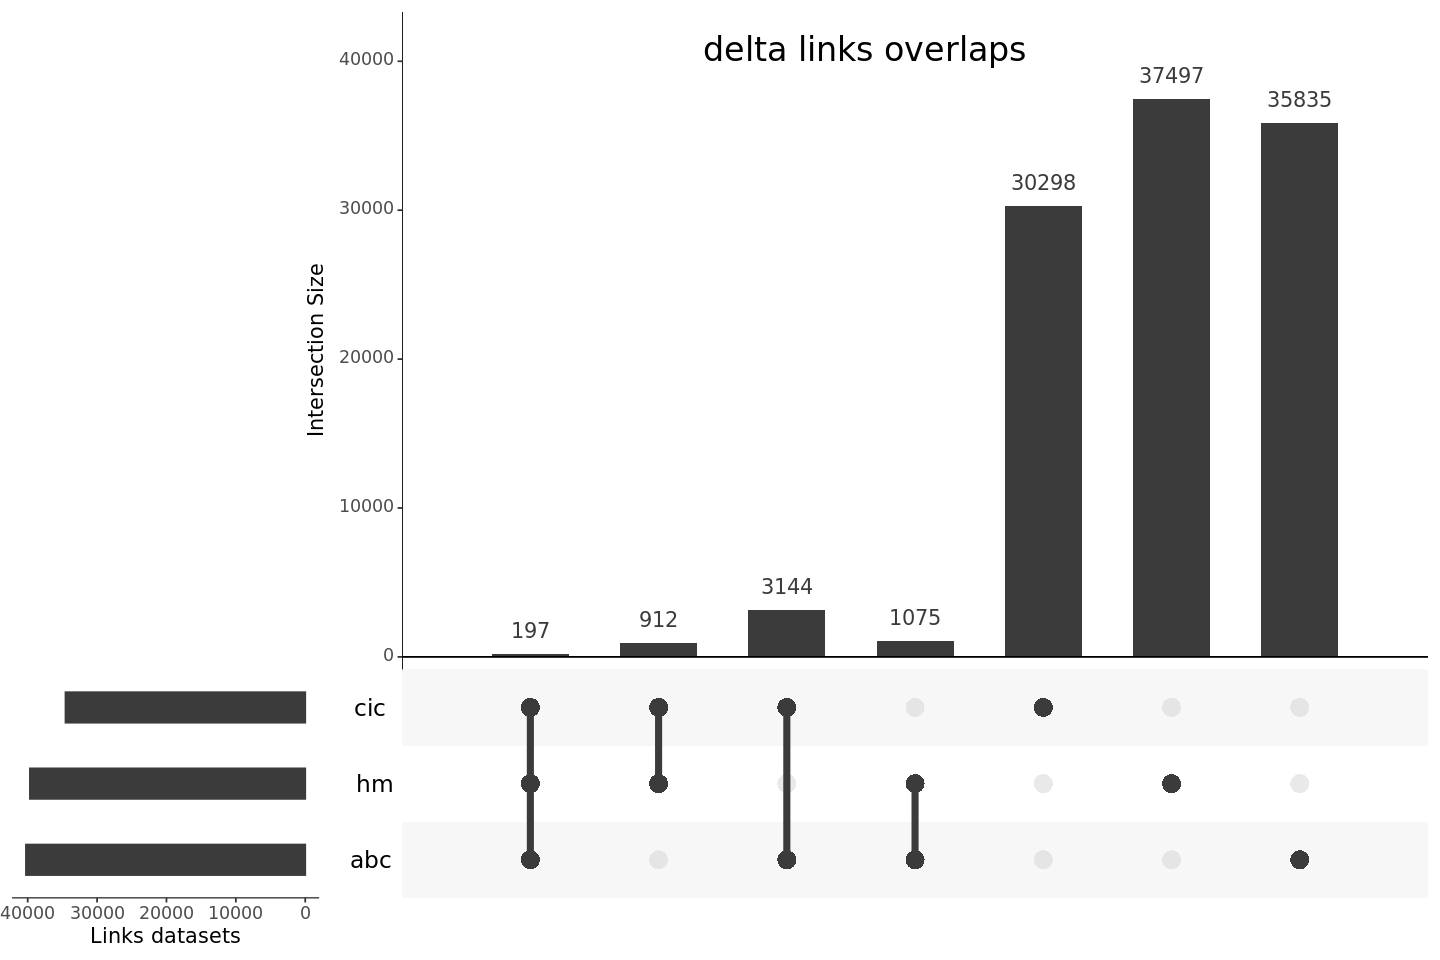

[1] "Total number of HM links: 68026"
[1] "Total number of ABC links: 56454"
[1] "Total number of Cicero links: 79465"
281.423 sec elapsed


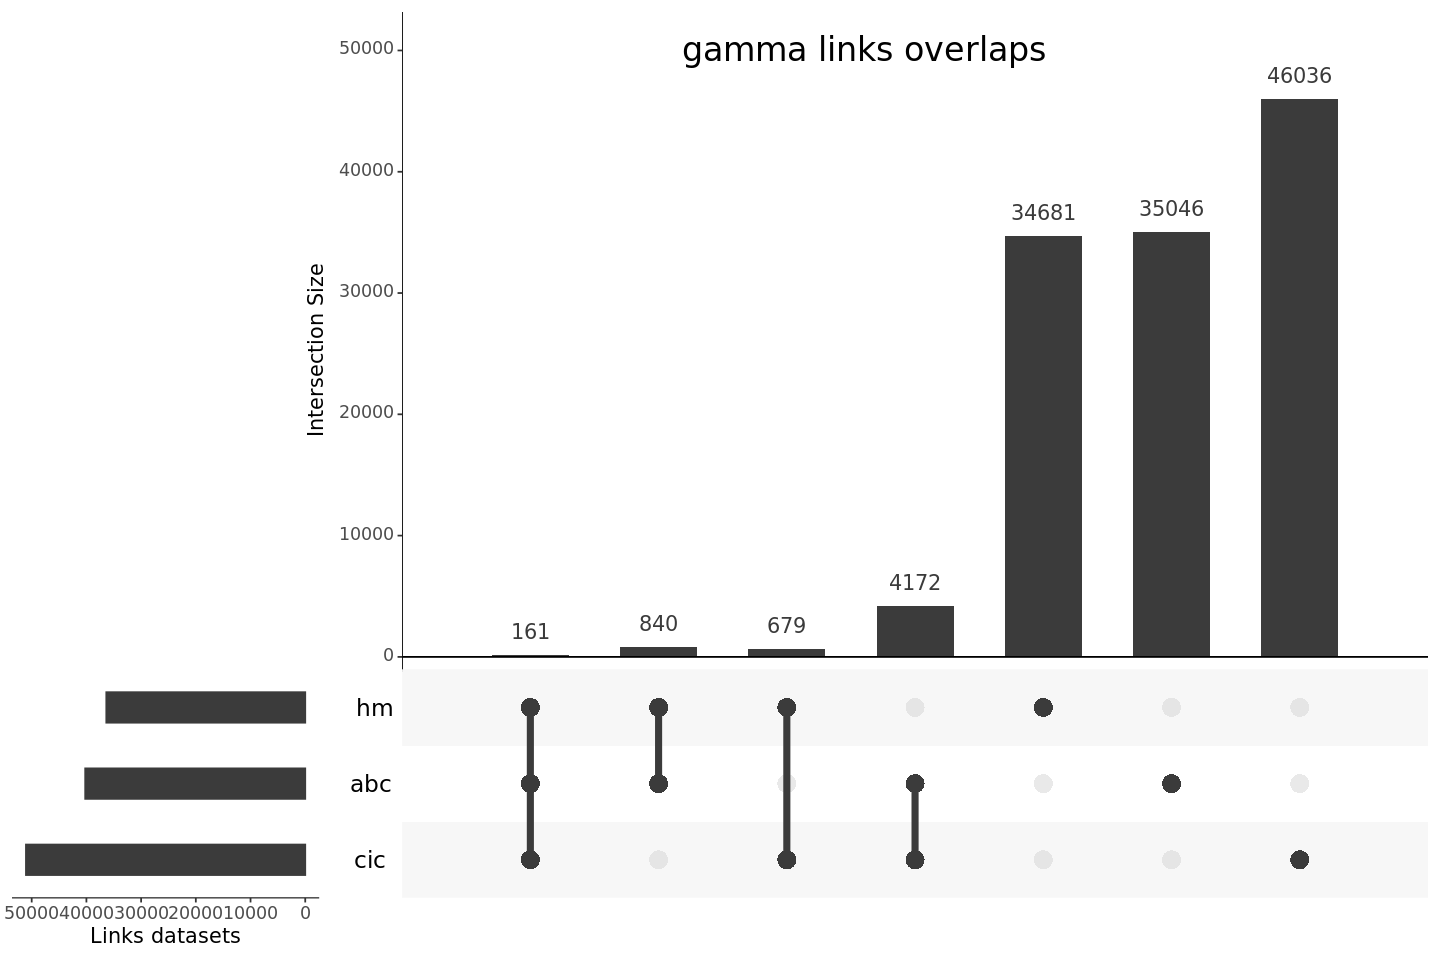

[1] "Total number of HM links: 49552"
[1] "Total number of ABC links: 48776"
[1] "Total number of Cicero links: 26658"
228.232 sec elapsed


In [ ]:
for (celltype in celltypes){
    options(repr.plot.width = 12, repr.plot.height = 8)
    tic()
    compare_links_plots(celltype, black_colors)
    toc()
}

### 5/16/23: redoing 3 link method overlaps for SMORES CP links

[1] "Total number of HM links: 114389"
[1] "Total number of ABC links: 39306"
[1] "Total number of Cicero links: 34789"
[1] "Total number of HM links: 71011"
[1] "Total number of ABC links: 40883"
[1] "Total number of Cicero links: 44644"


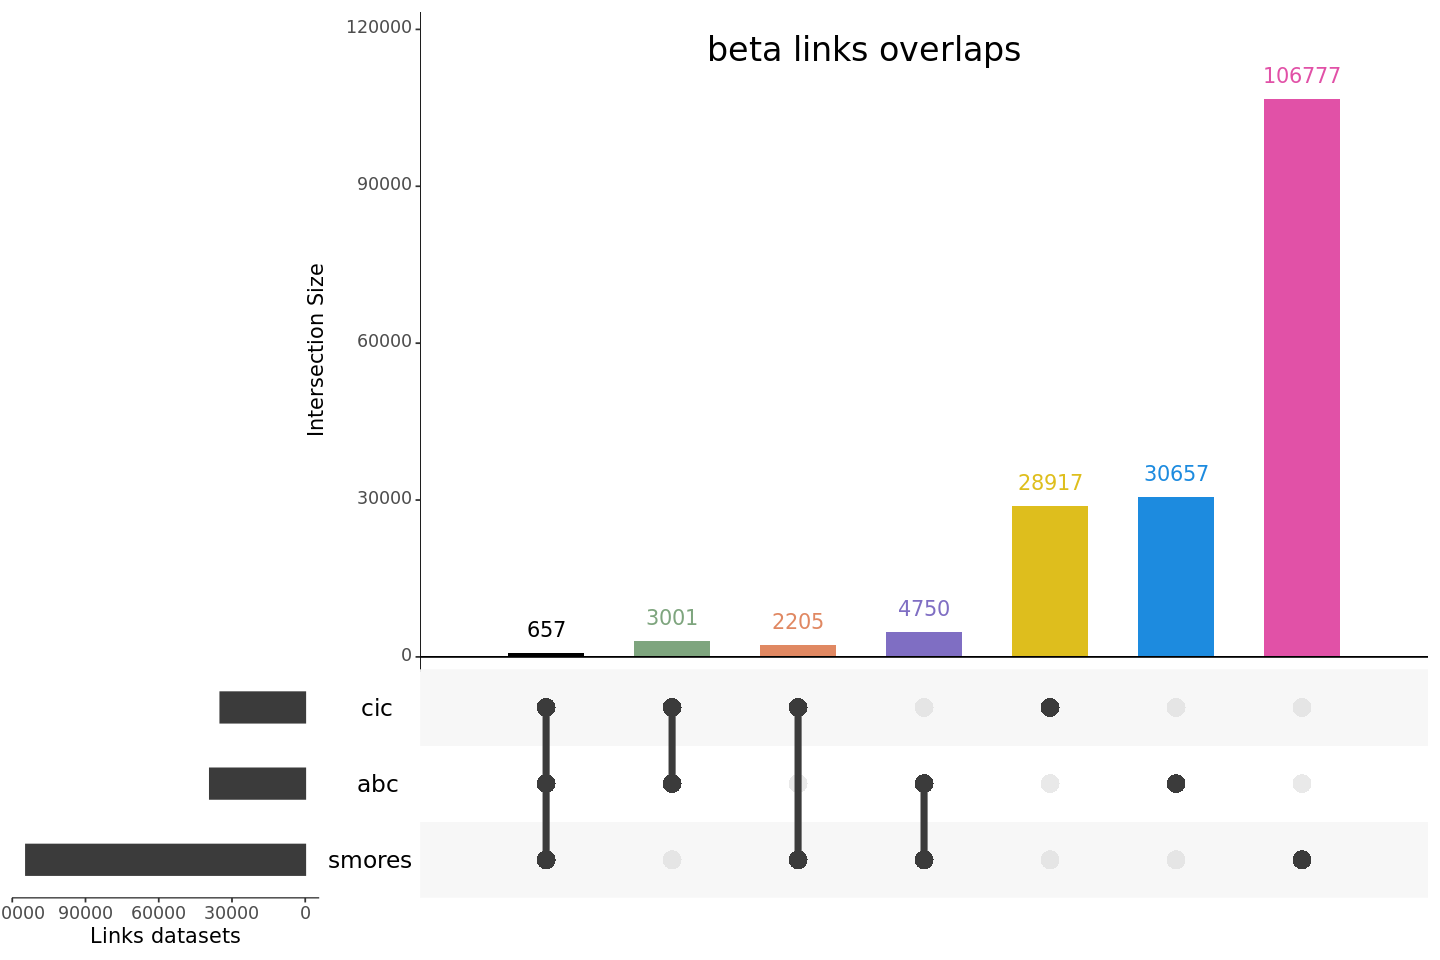

[1] "Total number of HM links: 32138"
[1] "Total number of ABC links: 40612"
[1] "Total number of Cicero links: 34556"


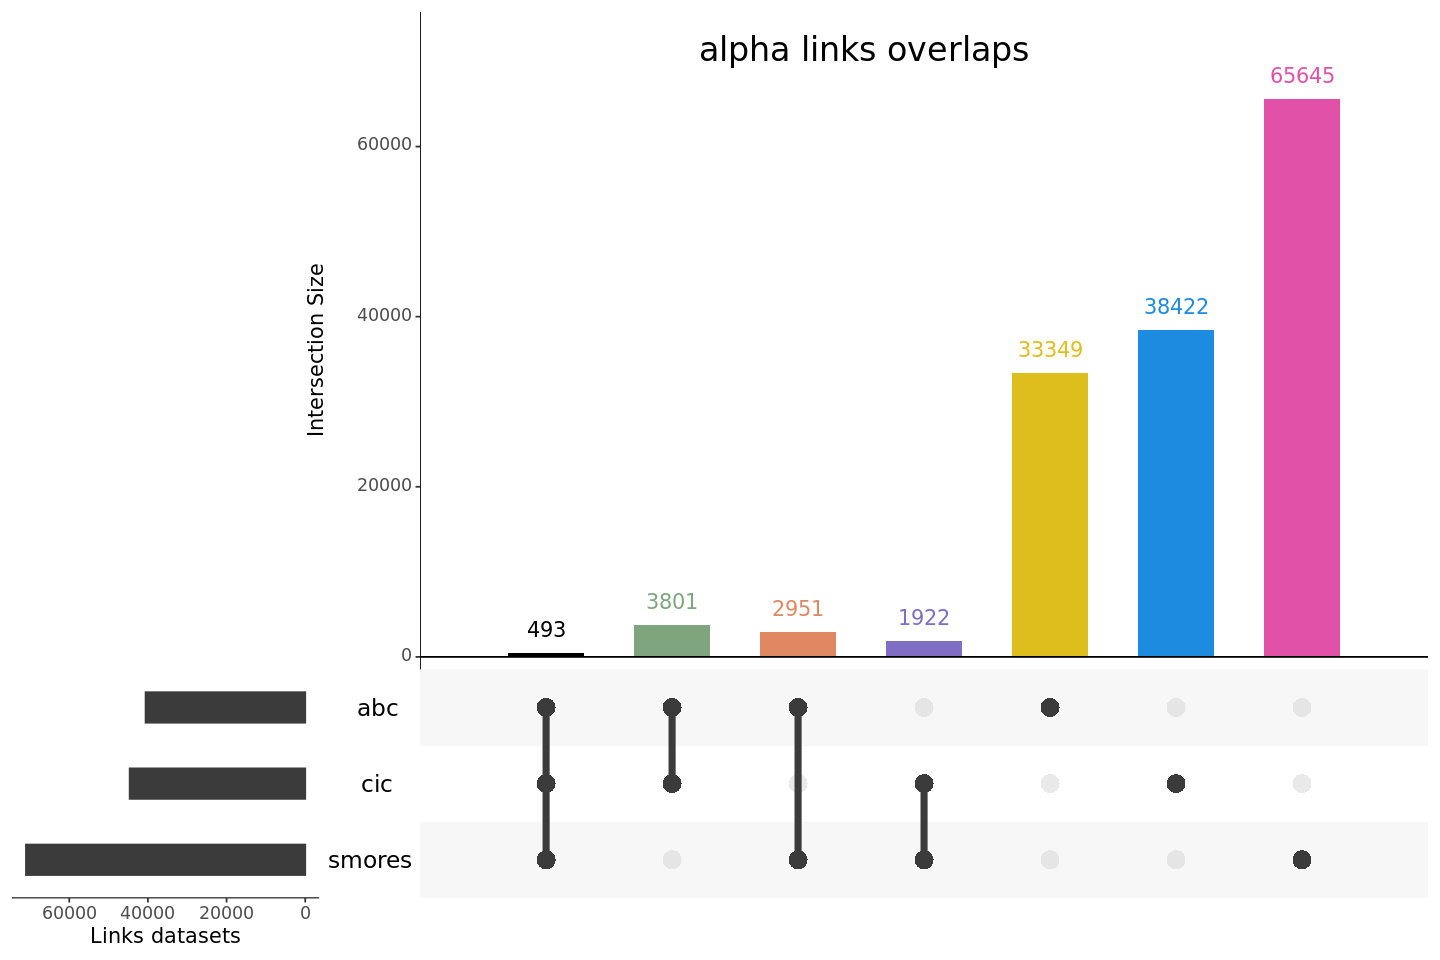

[1] "Total number of HM links: 29405"
[1] "Total number of ABC links: 40763"
[1] "Total number of Cicero links: 51066"


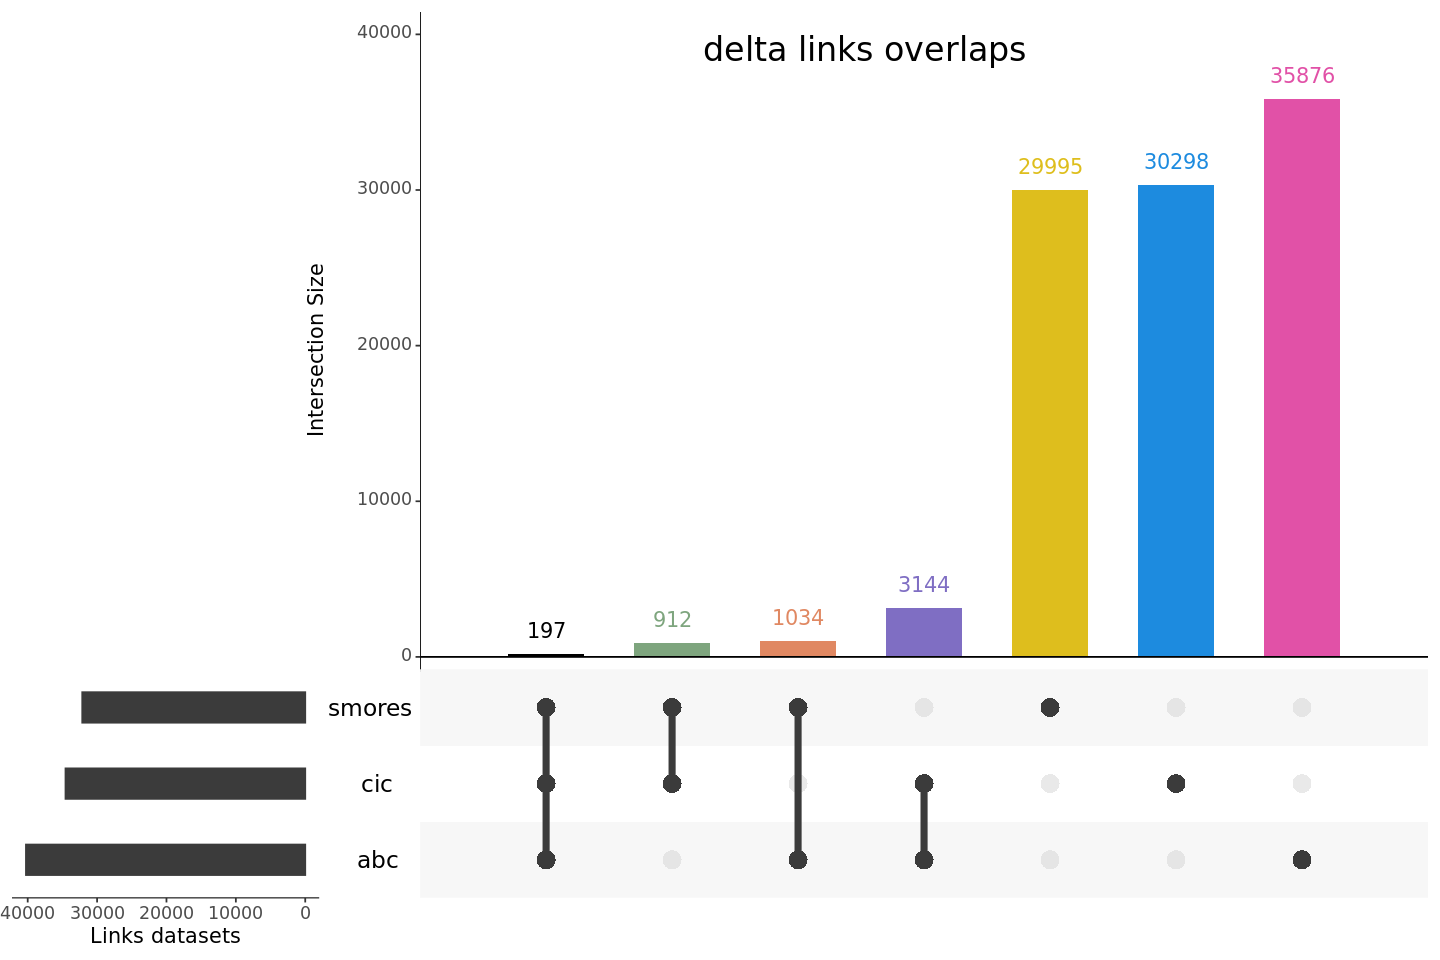

[1] "Total number of HM links: 58417"
[1] "Total number of ABC links: 56454"
[1] "Total number of Cicero links: 79465"


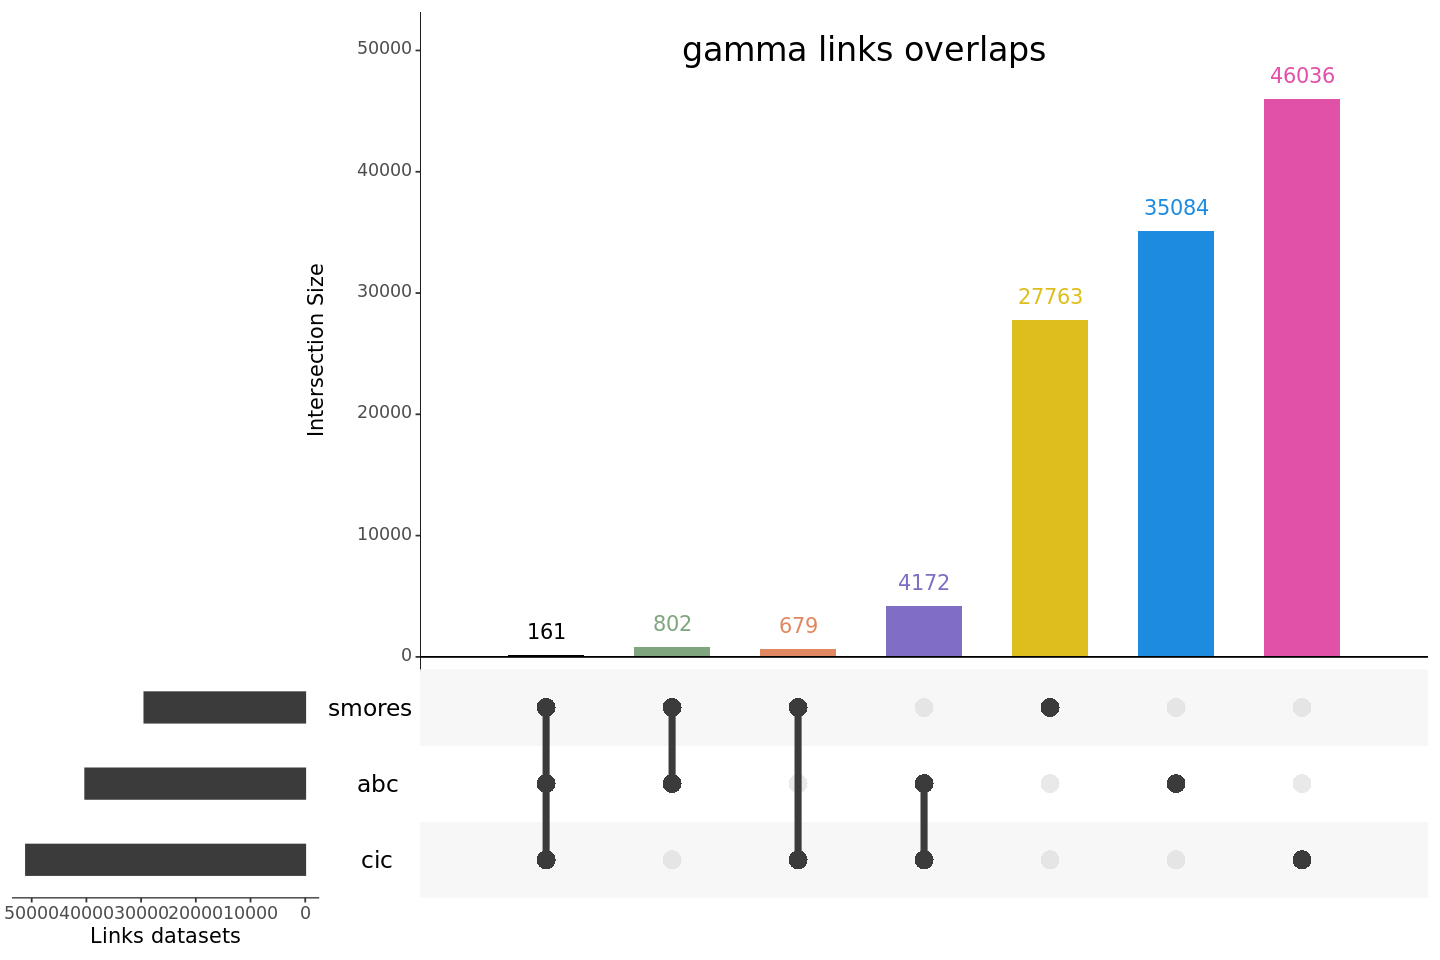

[1] "Total number of HM links: 39752"
[1] "Total number of ABC links: 48776"
[1] "Total number of Cicero links: 26658"


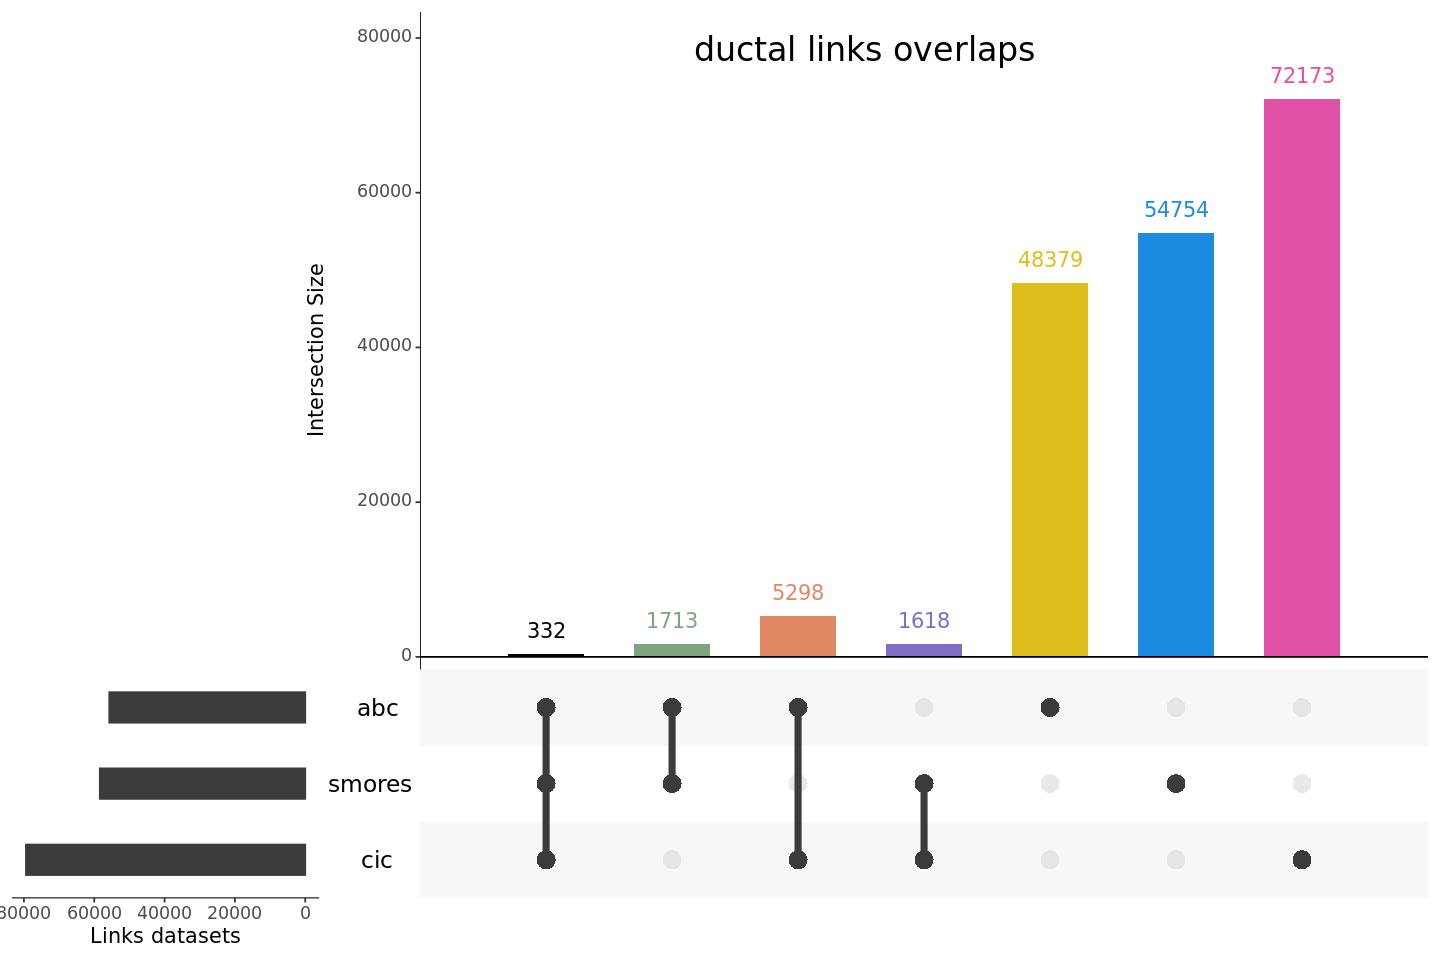

[1] "Total number of HM links: 385180"
[1] "Total number of ABC links: 39203"
[1] "Total number of Cicero links: 104174"


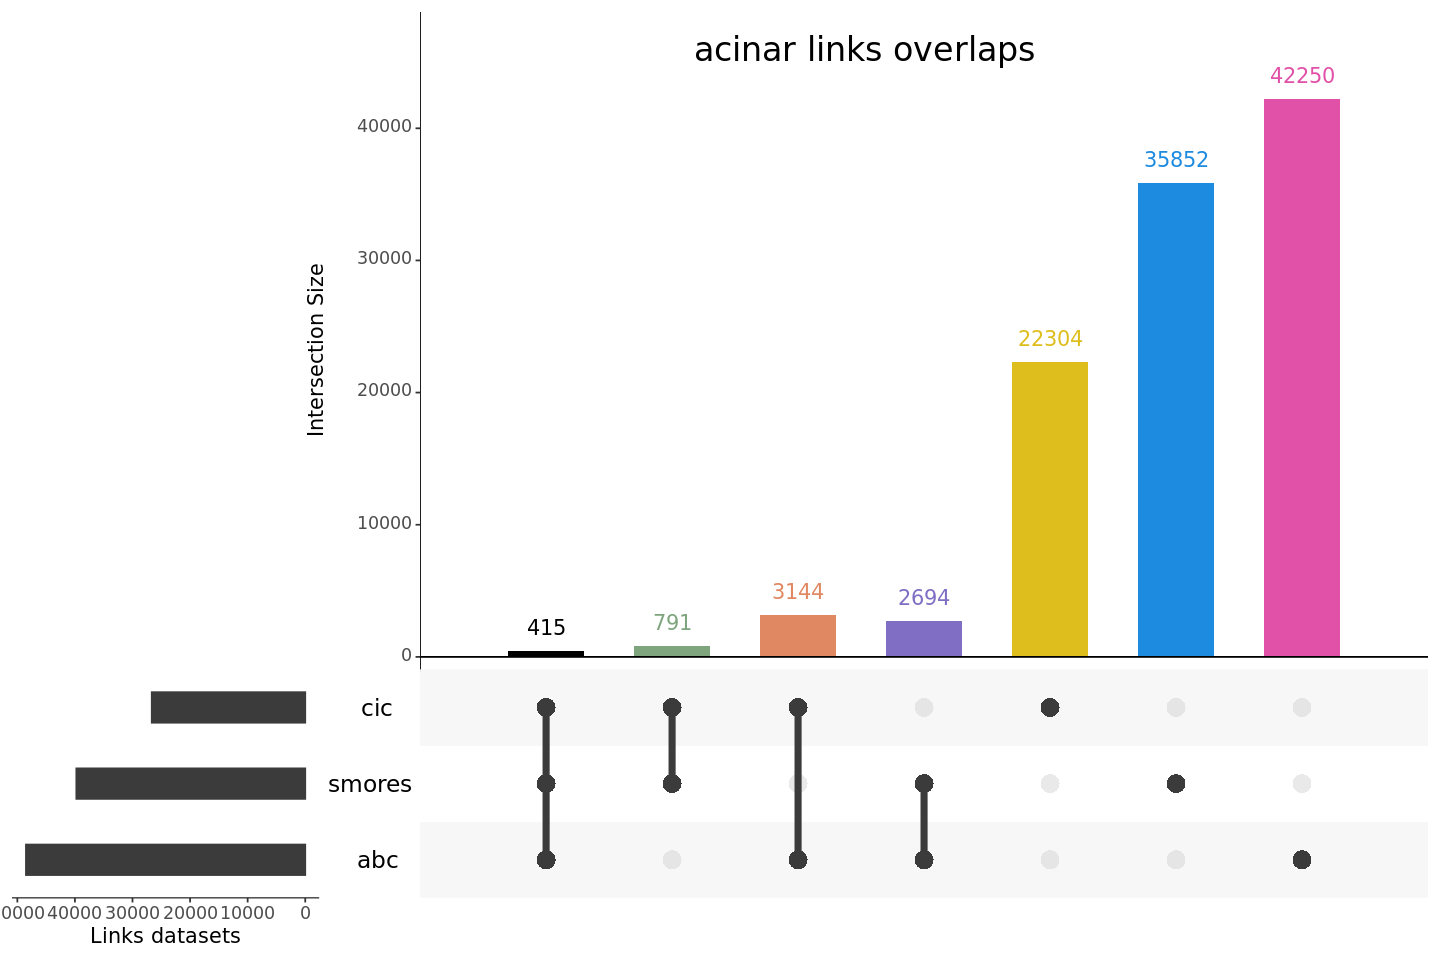

[1] "Total number of HM links: 410030"
[1] "Total number of ABC links: 39291"
[1] "Total number of Cicero links: 140453"


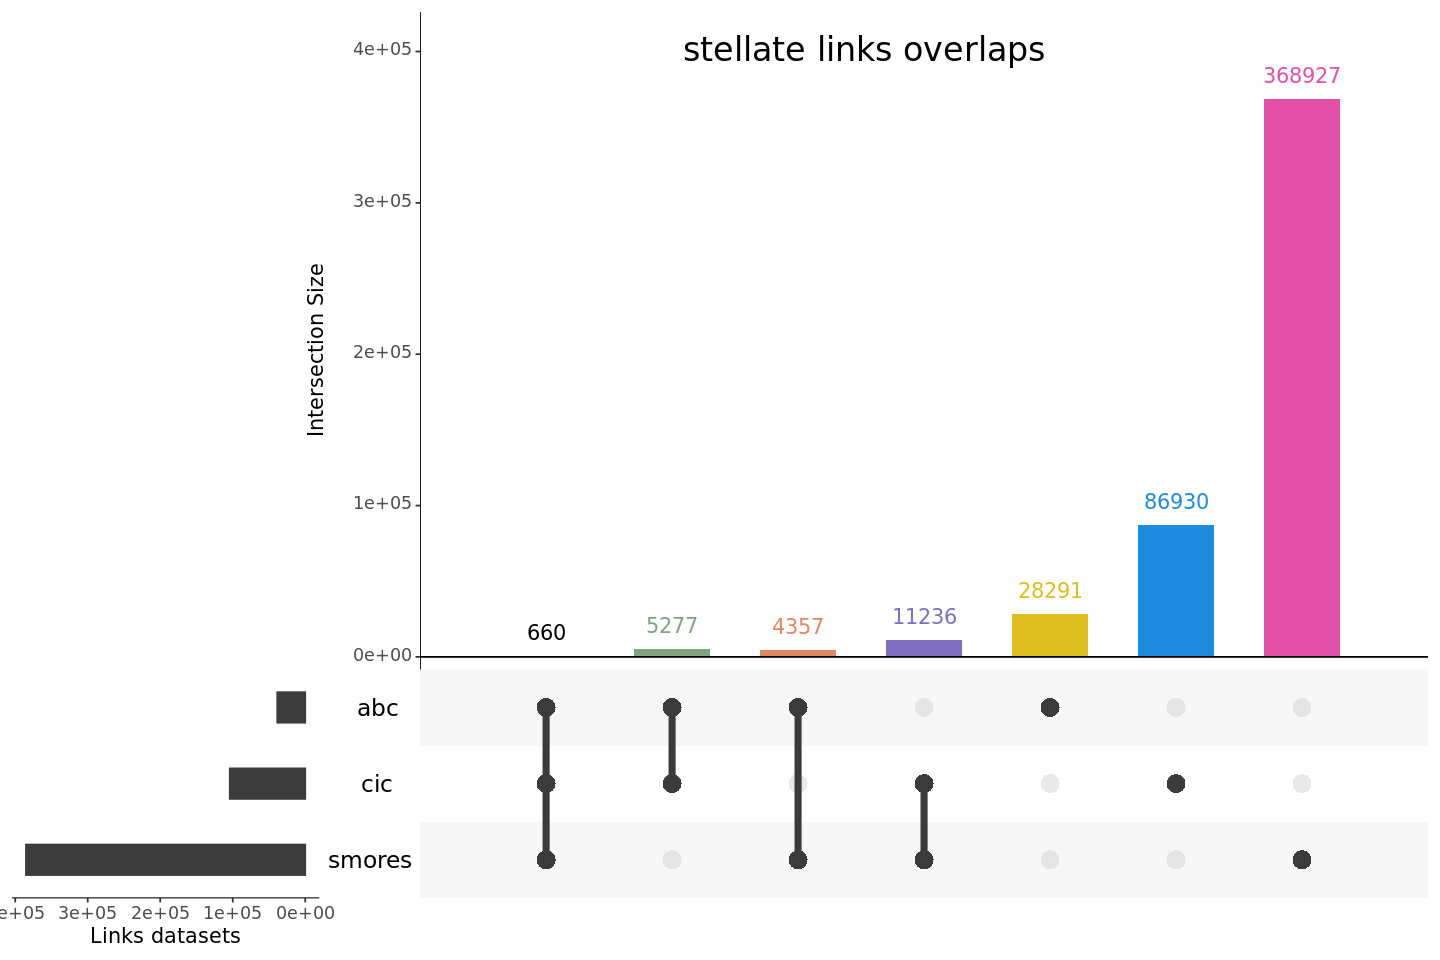

[1] "Total number of HM links: 177275"
[1] "Total number of ABC links: 34169"
[1] "Total number of Cicero links: 81840"


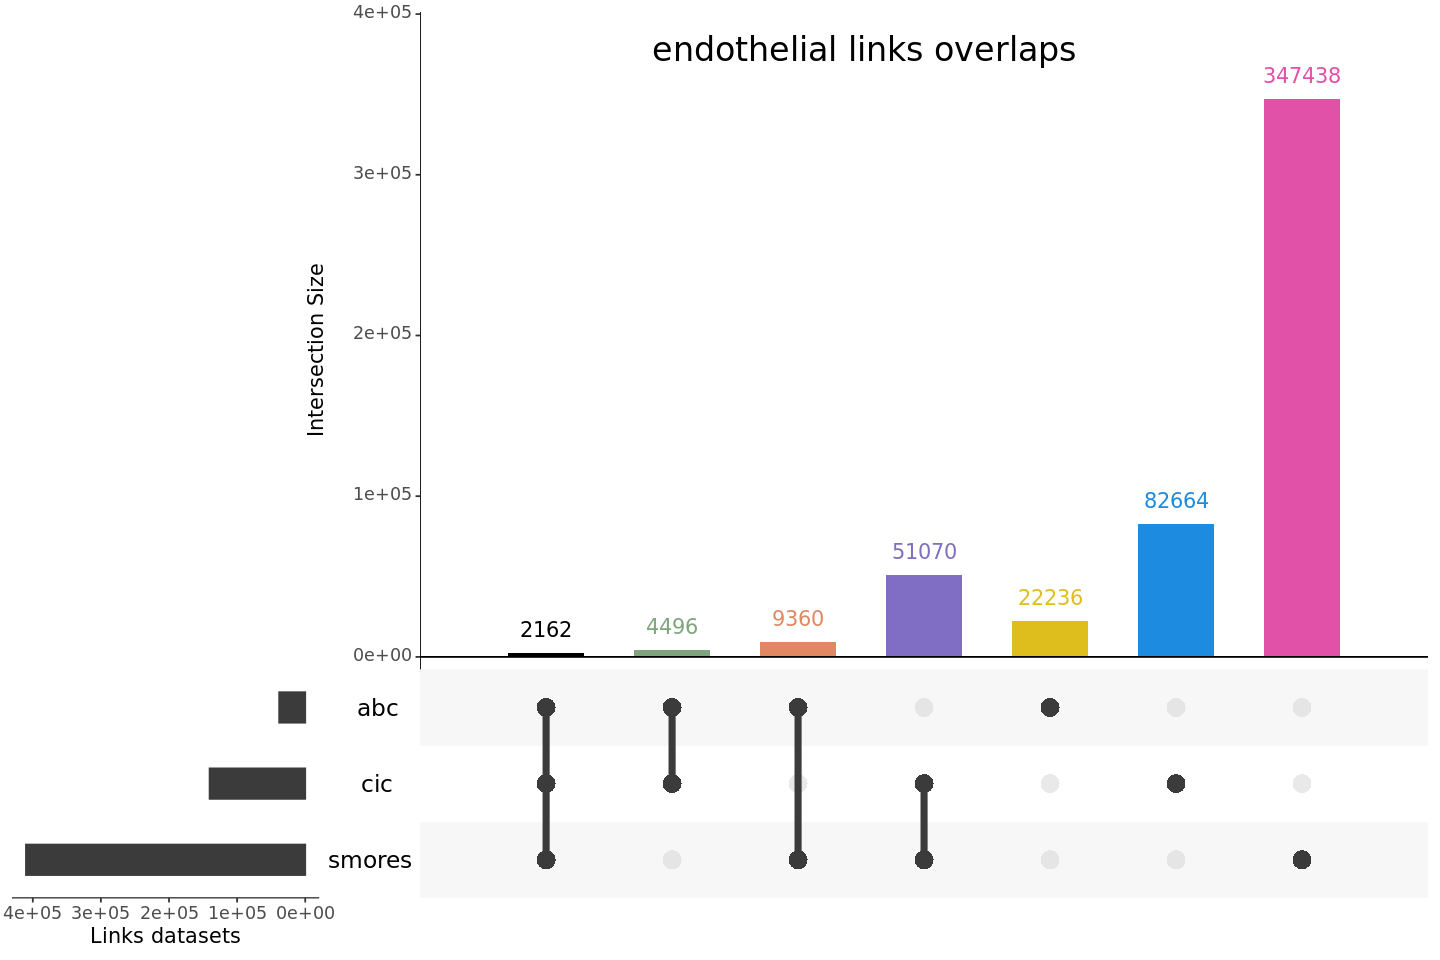

[1] "Total number of HM links: 363043"
[1] "Total number of ABC links: 36135"
[1] "Total number of Cicero links: 176497"


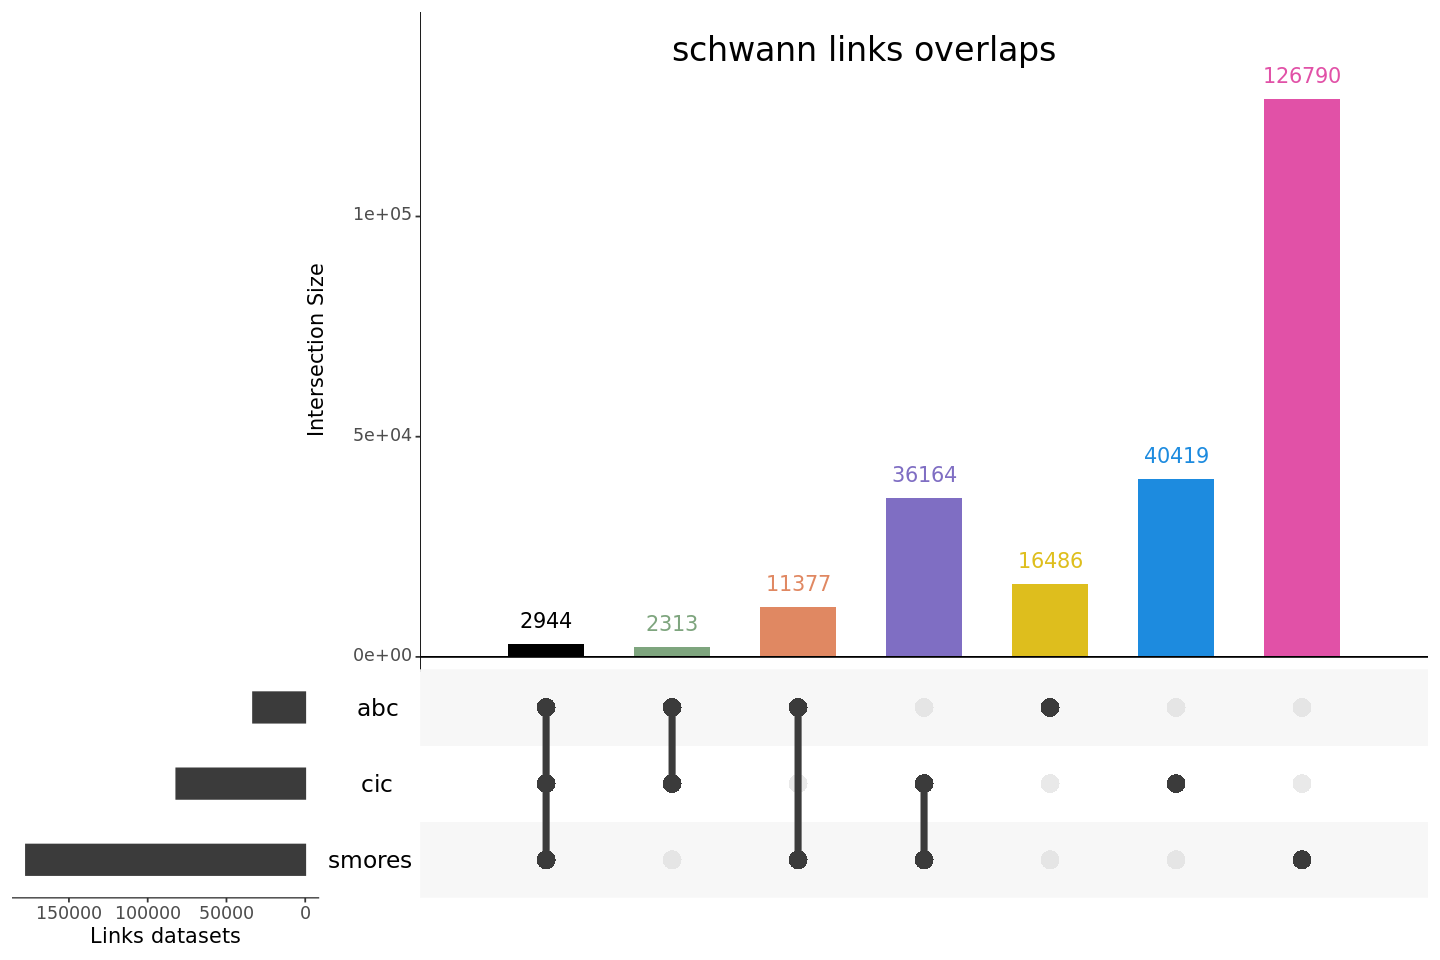

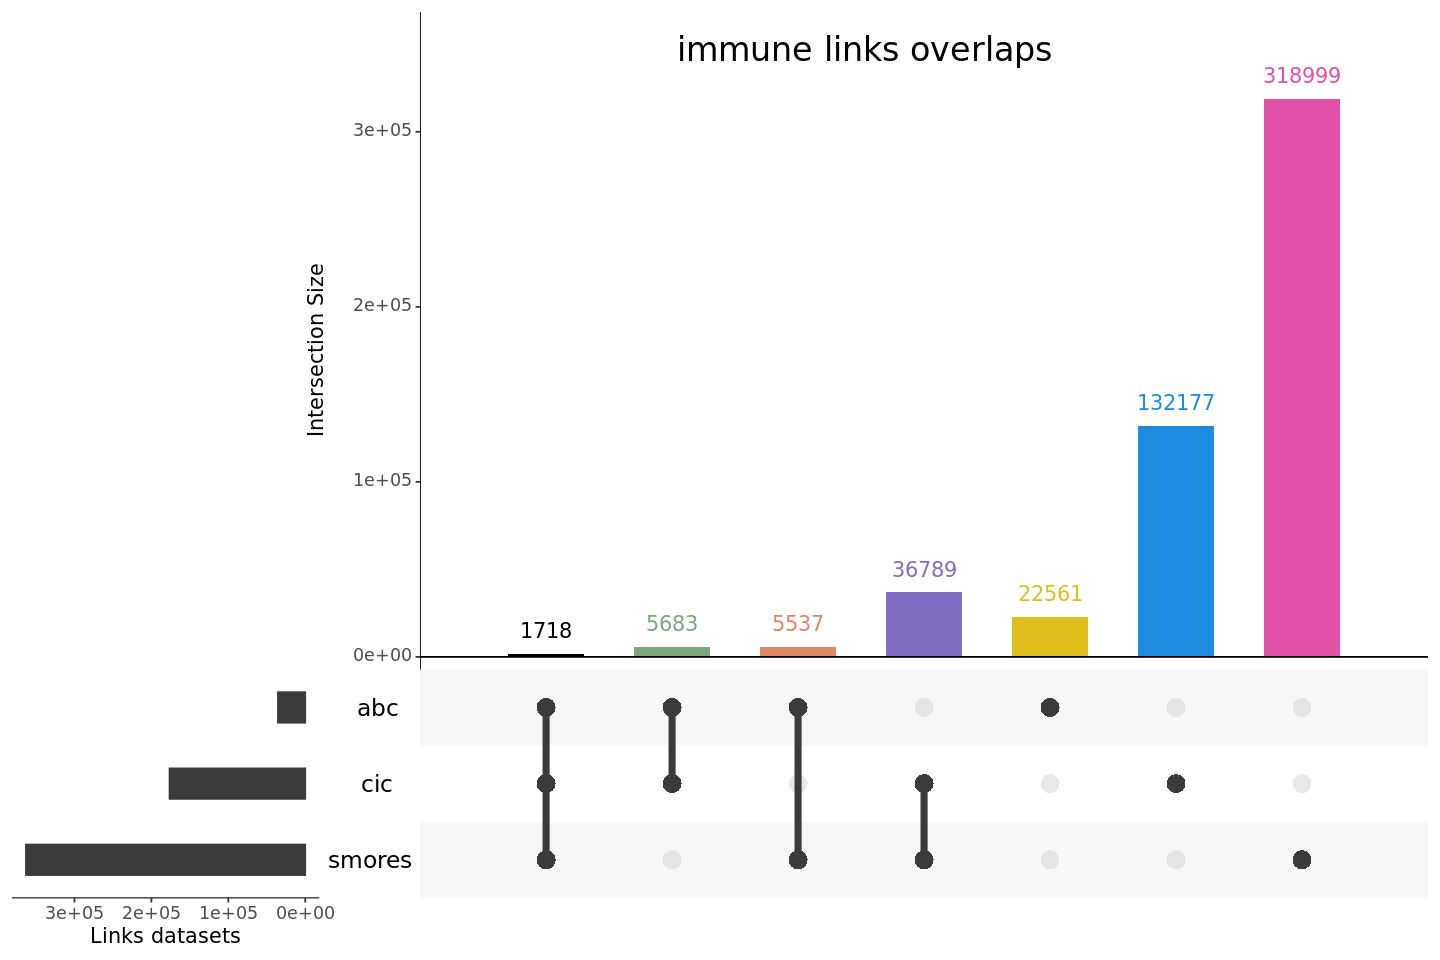

In [20]:
for (celltype in celltypes){
    compare_links_plots(celltype, colors)
}

# 3b. Write overlap summary from Upset

In [11]:
### Function to process links into a common format list
get_formatted_links <- function(row){
    cre = paste(row[[1]],row[[2]],row[[3]],sep='-')
    gene = row[[7]]
    return(paste(cre,gene,sep="_"))
}

In [12]:
### Function to get the gene range (ir) for a gene (window of 2kb around the TSS)
get_ir_fin <- function(gene, ref_df, b_away=1000000){
    if (gene %in% ref_df$V4 == TRUE){
        ref_df_cut = ref_df[ref_df$V4 ==gene,]
        chr        = as.character(ref_df_cut$V1)
        if (ref_df_cut$V6 == '-'){
            tss = max(c(ref_df_cut$V2,ref_df_cut$V3))
        } else {
            tss = min((c(ref_df_cut$V2,ref_df_cut$V3)))
        }
        start  = tss - b_away
        end    = tss + b_away
        ir     = IRanges(start = start, end = end, seqnames=chr)
        ir     = data.table(data.frame(ir))
        return(ir)
    } else {
        ir = IRanges(start = 0, end = 1, seqnames=NA)
        ir = data.table(data.frame(ir))
        return(ir)
    }
}

In [14]:
### Function to compare the celltype links from 3 methods using Upset (returns upset object for further work)
### Also writes outputs to files (using _ not - or & to separate link method names!!!)

### Previous method!!!! from May 2023

compare_links_write_sets <- function(celltype, overlap_outdir){
    # Set up file paths for each links set
    #hm_fp <- paste0(hm_prefix, celltype, '/', celltype, hm_suffix1)
    hm_fp <- paste0(hm_prefix, celltype, hm_suffix1)
    abc_fp <- file.path(abc_indir, sprintf('%s_mapped_links.bedpe',celltype))
    cic_fp <- file.path(cic_indir, sprintf('%s_links.CP_reformat.bedpe',celltype))
    
    # Read in links and convert to basic format
    hm_df <- read.table(hm_fp, sep='\t')
    hm_links <- gsub(" ","",apply(hm_df, 1, get_formatted_links))
    print(paste0('Total number of HM links: ', length(hm_links)))
    abc_df <- read.table(abc_fp, sep='\t')
    abc_links <- gsub(" ","",apply(abc_df, 1, get_formatted_links))
    print(paste0('Total number of ABC links: ', length(abc_links)))
    cic_df <- read.table(cic_fp, sep='\t')
    cic_links <- gsub(" ","",apply(cic_df, 1, get_formatted_links))
    print(paste0('Total number of Cicero links: ', length(cic_links)))
    
    # Make Upset plot object
    listInput <- list(hm = hm_links, abc = abc_links, cic=cic_links)
    p1 <- upset(fromList(listInput), order.by = "degree", sets.x.label="Links datasets",
                text.scale=c(1.5,1.5,1.5,1.5,2,2), point.size=5, line.size=2) #, main.bar.color=colors) 
    
    # Pull out links overlap table (which sets each link appears in)
    overlaps <- p1$New_data
    all_links <- unlist(listInput, use.names=FALSE)
    all_links <- all_links[!duplicated(all_links)]
    row.names(overlaps) <- all_links

    all_links_coords <- str_split_fixed(all_links,'_',2)[,1]
    coords <- str_split_fixed(all_links_coords, '-', 3)
    colnames(coords) <- c('chr','start','end')
    overlaps_fin <- cbind(coords, overlaps)
    fp1 <- file.path(overlap_outdir, sprintf('%s_all_links_overlap_table.txt',celltype))
    write.table(overlaps_fin, fp1, sep='\t', row.names=FALSE, col.names=TRUE, quote=FALSE)
    
    # Get sets of links for each overlap (prob a better way to do this)
    overlaps_fin$intersect <- paste(overlaps_fin$hm, overlaps_fin$abc, overlaps_fin$cic, sep='')
    intersect_sets <- c('111', '110', '101', '011', '100', '010', '001')
    intersect_key <- c('hm_abc_cic', 'hm_abc', 'hm_cic', 'abc_cic', 'hm', 'abc', 'cic')
    link_sets <- list()
    for (i in seq(length(intersect_sets))){
        link_sets[[intersect_key[i]]] <- row.names(overlaps_fin[overlaps_fin$intersect==intersect_sets[i],])
    }
                    
    # Build gene TSS coords reference 
    overlaps_fin$gene <- str_split_fixed(all_links, '_', 2)[,2]
    genes <- unique(overlaps_fin$gene)
    gene_coords <- rbindlist(lapply(genes, get_ir_fin, ref_df))
    tss_info <- as.data.frame(gene_coords[,c(4,1,2)])
    tss <- tss_info$start + 1000000
    tss_info$start <- tss
    tss_info$end <- tss+1
    colnames(tss_info) <- c('chr2','start2','end2')
    rownames(tss_info) <- genes
    
    # Output links sets to bedpe files with gene names
    outdir <- file.path(overlap_outdir,celltype)
    dir.create(outdir, showWarnings=FALSE)
    for (set in intersect_key){
        links <- link_sets[[set]]
        split_links <- str_split_fixed(links,'_',2)
        
        cres_df <- str_split_fixed(split_links[,1],'-',3)
        colnames(cres_df) <- c('chr1','start1','end1')
        
        gene_list <- split_links[,2]
        genes_df <- tss_info[gene_list,]
        
        df_fin <- cbind(cres_df,genes_df, as.data.frame(gene_list))
        out_fp <- file.path(outdir, sprintf('overlap_links_%s.bedpe',set))
        write.table(df_fin, out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    }
}

In [ ]:
for (celltype in celltypes){
    tic()
    compare_links_write_sets(celltype, overlap_outdir)
    toc()
}

## 12/11/23: New method (make one summary bedpe file per cell type)
Columns:
- Left coords: cRE (coords from merged overlap, should be what we're already using)
- Right coords: gene promoter (just 1bp window from ref_df (actual TSS)
- Gene name
- Method scores (SMORES, ABC, Cicero), NA if not found by method
- Found methods (string of all link methods which found this link)

In [137]:
### Function to process links into a common format list
get_formatted_links <- function(row){
    cre = paste(row[[1]],row[[2]],row[[3]],sep='-')
    gene = row[[7]]
    return(paste(cre,gene,sep="_"))
}

In [138]:
### Function to pull the necessary sig link score for a cRE-gene pair in a links df
get_link_score <- function(row, method_col, link_df){
    # Pull out relevant info for the link method of choice
    link <- paste(paste(row[[1]],row[[2]],row[[3]],sep='-'),row[[7]],sep='_')

    # Check if the link is found in the method of interest
    found <- ifelse(row[[method_col]] == 1, TRUE, FALSE)
    if (found == TRUE){
        # Get link score (if more than one link due to mapping overlap, take top score)
        if(dim(link_df[link_df$links==link,])[1] > 1){
            score <- max(link_df[link_df$links==link,]$V8)
        } else {
            score <- link_df[link_df$links==link,]$V8
        }
    } else {
        score <- NA
    }
    return(score)
}

In [139]:
### Function to compare the celltype links from 3 methods using Upset (returns upset object for further work)
### Also writes outputs to files (using _ not - or & to separate link method names!!!)

### New method that makes combined bedpe for all sig links per cell type (with info on which methods they were called in)
compare_links_write_bedpe <- function(celltype, tss_df, overlap_outdir){
    # Set up file paths for each links set
    hm_fp <- paste0(hm_prefix, celltype, hm_suffix1)
    abc_fp <- file.path(abc_indir, sprintf('%s_mapped_links.bedpe',celltype))
    cic_fp <- file.path(cic_indir, sprintf('%s_links.CP_reformat.bedpe',celltype))
    
    # Read in links and convert to basic format (add links info back to dfs for use later)
    hm_df <- read.table(hm_fp, sep='\t')
    hm_links <- gsub(" ","",apply(hm_df, 1, get_formatted_links))
    hm_df$links <- hm_links
    print(paste0('Total number of HM links: ', length(hm_links)))
    abc_df <- read.table(abc_fp, sep='\t')
    abc_links <- gsub(" ","",apply(abc_df, 1, get_formatted_links))
    abc_df$links <- abc_links
    print(paste0('Total number of ABC links: ', length(abc_links)))
    cic_df <- read.table(cic_fp, sep='\t')
    cic_links <- gsub(" ","",apply(cic_df, 1, get_formatted_links))
    cic_df$links <- cic_links
    print(paste0('Total number of Cicero links: ', length(cic_links)))
    
    # Make Upset plot object
    listInput <- list(hm = hm_links, abc = abc_links, cic=cic_links)
    p1 <- upset(fromList(listInput), order.by = "degree", sets.x.label="Links datasets",
                text.scale=c(1.5,1.5,1.5,1.5,2,2), point.size=5, line.size=2) #, main.bar.color=colors) 
    
    # Pull out links overlap table (which sets each link appears in)
    overlaps <- p1$New_data
    all_links <- unlist(listInput, use.names=FALSE)
    all_links <- all_links[!duplicated(all_links)]
    row.names(overlaps) <- all_links
    
    # Get cRE coords into columns
    all_links_coords <- str_split_fixed(all_links,'_',2)[,1]
    coords <- str_split_fixed(all_links_coords, '-', 3)
    colnames(coords) <- c('chr','start','end')
    overlaps_fin <- cbind(coords, overlaps)

    # Get gene coords from the TSS df
    overlaps_fin$gene <- str_split_fixed(row.names(overlaps_fin),'_',2)[,2]
    bedpe <- cbind(overlaps_fin[,c(1,2,3)], tss_df[overlaps_fin$gene,], overlaps_fin[,c(7,4,5,6)])
    
    # Extract link scores from each method (takes about 10mins)
    bedpe$hm_score <- unlist(apply(bedpe, 1, get_link_score, 8, hm_df))
    bedpe$abc_score <- unlist(apply(bedpe, 1, get_link_score, 9, abc_df))
    bedpe$cic_score <- unlist(apply(bedpe, 1, get_link_score, 10, cic_df))
    
    # Create a max score column (for genome browser don't want any NAs in score col)
    scores <- bedpe[,c(11,12,13)]
    bedpe$max_score <- unlist(apply(scores, 1, max, na.rm=T))

    # Add column with string of which method/s called the link
    methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc','cic')
    names(methods) <- c('111','110','101','011','100','010','001')
    methods_bin <- paste0(as.character(bedpe$hm),as.character(bedpe$abc),as.character(bedpe$cic))
    bedpe$method_str <- methods[methods_bin]

    #rm binary columns and put max score before the other scores
    bedpe_fin <- bedpe[,c(1,2,3,4,5,6,7,14,11,12,13,15)] 

    #write to a file
    fp1 <- file.path(overlap_outdir,sprintf('%s_all_methods_links.bedpe',celltype))
    write.table(bedpe_fin,fp1,sep='\t',row.names=F,col.names=F,quote=F)

    #also write version with header
    fp2 <- gsub('links.bedpe','links.wHeader.bedpe',fp1)
    write.table(bedpe_fin,fp2,sep='\t',row.names=F,col.names=T,quote=F)
}

In [140]:
# Build gene TSS coords reference -- should be +249 and +250 (to get 0-indexed, what the epigenome browser does) 
promoter_df$tss <- paste(promoter_df$V1, promoter_df$V2 + 250, promoter_df$V2 + 251, sep='-')
tss_df <- as.data.frame(str_split_fixed(promoter_df$tss, '-', 3))
colnames(tss_df) <- c('chr2','start2','end2')
row.names(tss_df) <- promoter_df$V4
head(tss_df)

,chr2,start2,end2
,<chr>,<chr>,<chr>
MIR1302-2HG,chr1,29554,29555
FAM138A,chr1,36081,36082
OR4F5,chr1,65419,65420
AL627309.1,chr1,133723,133724
AL627309.3,chr1,91105,91106
AL627309.2,chr1,140339,140340


In [141]:
for (celltype in h3k27ac_celltypes){
    tic()
    compare_links_write_bedpe(celltype, tss_df, overlap_outdir2)
    toc()
}

### NOT sure if this is working on the smaller cell types???? Gonna just leave it to run but yeah no idea -- so it did run, there's just so many links for the smaller cell types (issue with SMORES) so it took forever

In [142]:
for (celltype in no_h3k27ac_celltypes){
    tic()
    compare_links_write_bedpe(celltype, tss_df, overlap_outdir2)
    toc()
}

[1] "Total number of HM links: 385180"
[1] "Total number of ABC links: 39203"
[1] "Total number of Cicero links: 104174"
18927.479 sec elapsed
[1] "Total number of HM links: 410030"
[1] "Total number of ABC links: 39291"
[1] "Total number of Cicero links: 140453"
18077.108 sec elapsed
[1] "Total number of HM links: 177275"
[1] "Total number of ABC links: 34169"
[1] "Total number of Cicero links: 81840"
2300.227 sec elapsed
[1] "Total number of HM links: 363043"
[1] "Total number of ABC links: 36135"
[1] "Total number of Cicero links: 176497"
12939.72 sec elapsed


##  12/13/23: Converting gene coords to MANE v1.0 to match the genome browser
For most link methods we link peaks to genes and then assign gene coords for the bedpe based on reference files (currently gencode v32). The WashU epigenome browser uses different gene annotations, my favorite being MANE v1.0 because it's the most simple. However these often don't match and so the links will look like they're not actually connected to the right gene or just plotted incorrectly... Obviously that's NOT GOOD.

I'm going to write a script to convert the gene coords from a links bedpe to MANE v1.0 coords and run that on the combined links files. 

NOTE: this is kinda sketchy to do for cicero links bc they are peak-peak and then we map peaks to genes based on gene annotations... so gets a bit complicated, but gonna just do this for now and see if there's anything egregious... definitely should go back to the cicero processing and use MANE coords then (and then remake the combined files and these files (ugh)).

### Downloading MANE v1.0 annotations and making promoter/TSS files
MANE v1.0 ftp site: https://ftp.ncbi.nlm.nih.gov/refseq/MANE/MANE_human/release_1.0/

Wasn't totally sure which files to download... but gonna just start with the summary file: https://ftp.ncbi.nlm.nih.gov/refseq/MANE/MANE_human/release_1.0/MANE.GRCh38.v1.0.summary.txt.gz

In [20]:
# Create gene TSS file from the MANE v1.0 annotations
mane_dir <- '/nfs/lab/projects/multiomic_islet/references/MANE_v1.0'
mane_fp <- file.path(mane_dir,'MANE.GRCh38.v1.0.summary.txt.gz')
mane_df <- vroom::vroom(mane_fp)
mane_df_select <- subset(mane_df, MANE_status=='MANE Select')
mane_df_select$chrom <- paste0('chr',mane_df_select$GRCh38_chr)
head(mane_df_select)

get_TSS <- function(row){
    start <- row[['chr_start']]
    end <- row[['chr_end']]
    strand <- row[['chr_strand']]
    if (strand == '+'){
        tss <- as.numeric(start)
    } else if (strand == '-'){
        tss <- as.numeric(end)
    }
    return(tss)
}
#make TSS bed and write to file
mane_df_select$tss <- apply(mane_df_select,1,get_TSS)
mane_df_select$tss_start <- mane_df_select$tss - 1
mane_tss <- mane_df_select[,c('chrom','tss_start','tss','symbol','chr_strand','Ensembl_Gene')]
head(mane_tss)
tss_fp <- file.path(mane_dir,'MANE.GRCh38.v1.0.TSS0index.bed')
write.table(mane_tss, tss_fp, sep='\t', row.names=F, col.names=F, quote=F)

#make promoter bed and write to file
mane_df_select$prom_start <- mane_df_select$tss-250
mane_df_select$prom_end <- mane_df_select$tss+250
mane_prom <- mane_df_select[,c('chrom','prom_start','prom_end','symbol','chr_strand','Ensembl_Gene')]
head(mane_prom)
prom_fp <- file.path(mane_dir, 'MANE.GRCh38.v1.0.TSS500bp.bed')
write.table(mane_prom, prom_fp, sep='\t', row.names=F, col.names=F, quote=F)

Rows: 19120 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): #NCBI_GeneID, Ensembl_Gene, HGNC_ID, symbol, name, RefSeq_nuc, Ref...
dbl  (2): chr_start, chr_end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#NCBI_GeneID,Ensembl_Gene,HGNC_ID,symbol,name,RefSeq_nuc,RefSeq_prot,Ensembl_nuc,Ensembl_prot,MANE_status,GRCh38_chr,chr_start,chr_end,chr_strand,chrom
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
GeneID:1,ENSG00000121410.12,HGNC:5,A1BG,alpha-1-B glycoprotein,NM_130786.4,NP_570602.2,ENST00000263100.8,ENSP00000263100.2,MANE Select,19,58345183,58353492,-,chr19
GeneID:2,ENSG00000175899.15,HGNC:7,A2M,alpha-2-macroglobulin,NM_000014.6,NP_000005.3,ENST00000318602.12,ENSP00000323929.8,MANE Select,12,9067708,9115919,-,chr12
GeneID:9,ENSG00000171428.15,HGNC:7645,NAT1,N-acetyltransferase 1,NM_000662.8,NP_000653.3,ENST00000307719.9,ENSP00000307218.4,MANE Select,8,18210109,18223689,+,chr8
GeneID:10,ENSG00000156006.5,HGNC:7646,NAT2,N-acetyltransferase 2,NM_000015.3,NP_000006.2,ENST00000286479.4,ENSP00000286479.3,MANE Select,8,18391282,18401218,+,chr8
GeneID:12,ENSG00000196136.18,HGNC:16,SERPINA3,serpin family A member 3,NM_001085.5,NP_001076.2,ENST00000393078.5,ENSP00000376793.3,MANE Select,14,94612391,94624053,+,chr14
GeneID:13,ENSG00000114771.14,HGNC:17,AADAC,arylacetamide deacetylase,NM_001086.3,NP_001077.2,ENST00000232892.12,ENSP00000232892.6,MANE Select,3,151814116,151828488,+,chr3


chrom,tss_start,tss,symbol,chr_strand,Ensembl_Gene
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr19,58353491,58353492,A1BG,-,ENSG00000121410.12
chr12,9115918,9115919,A2M,-,ENSG00000175899.15
chr8,18210108,18210109,NAT1,+,ENSG00000171428.15
chr8,18391281,18391282,NAT2,+,ENSG00000156006.5
chr14,94612390,94612391,SERPINA3,+,ENSG00000196136.18
chr3,151814115,151814116,AADAC,+,ENSG00000114771.14


chrom,prom_start,prom_end,symbol,chr_strand,Ensembl_Gene
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr19,58353242,58353742,A1BG,-,ENSG00000121410.12
chr12,9115669,9116169,A2M,-,ENSG00000175899.15
chr8,18209859,18210359,NAT1,+,ENSG00000171428.15
chr8,18391032,18391532,NAT2,+,ENSG00000156006.5
chr14,94612141,94612641,SERPINA3,+,ENSG00000196136.18
chr3,151813866,151814366,AADAC,+,ENSG00000114771.14


### Use TSS files to convert gene coords
## ALSO SET SCORE COLUMN TO 1 FOR EVERYTHING

In [21]:
# Read in MANE TSS info
mane_dir <- '/nfs/lab/projects/multiomic_islet/references/MANE_v1.0'
tss_fp <- file.path(mane_dir,'MANE.GRCh38.v1.0.TSS0index.bed')
mane_tss <- read.table(tss_fp, sep='\t')
colnames(mane_tss) <- c('chr2','start2','end2','gene','strand','ensembl')
row.names(mane_tss) <- mane_tss$gene
head(mane_tss)

,chr2,start2,end2,gene,strand,ensembl
,<chr>,<int>,<int>,<chr>,<chr>,<chr>
A1BG,chr19,58353491,58353492,A1BG,-,ENSG00000121410.12
A2M,chr12,9115918,9115919,A2M,-,ENSG00000175899.15
NAT1,chr8,18210108,18210109,NAT1,+,ENSG00000171428.15
NAT2,chr8,18391281,18391282,NAT2,+,ENSG00000156006.5
SERPINA3,chr14,94612390,94612391,SERPINA3,+,ENSG00000196136.18
AADAC,chr3,151814115,151814116,AADAC,+,ENSG00000114771.14


In [23]:
# Because I used the gencode gene coords when making all the links, there are genes in that set that aren't in MANE
# So will need to add gencode info for the missing genes (probably lncRNAs and other ncRNA)
# Build gencode gene TSS coords reference -- should be +249 and +250 (to get 0-indexed, what the epigenome browser does) 
promoter_df$tss <- paste(promoter_df$V1, promoter_df$V2 + 249, promoter_df$V2 + 250, sep='-')
gencode_tss <- cbind(as.data.frame(str_split_fixed(promoter_df$tss, '-', 3)),promoter_df[,c(4,6)])
colnames(gencode_tss) <- c('chr2','start2','end2','gene','strand')
row.names(gencode_tss) <- promoter_df$V4

#save to a file so don't have to do this everytime
gencode_tss_fp <- '/nfs/lab/ABC/references/gene_coords.gencodev32.hg38.TSS0index.bed'
write.table(gencode_tss, gencode_tss_fp, sep='\t', row.names=F, col.names=F, quote=F)

In [13]:
# Combine two gene coords sets (MANE + all gencode stuff not in MANE)
tss_ref <- rbind(mane_tss[,c(1,2,3)],gencode_tss[!row.names(gencode_tss) %in% row.names(mane_tss),])

In [14]:
### Function to read in a bedpe and convert the 2nd set of coords to those from the tss_ref

convert_tss_coords <- function(bedpe_fp, tss_ref){
    # Read in original bedpe
    bedpe <- vroom::vroom(bedpe_fp)

    # get the coords for genes from the new tss_ref and replace the appropriate columns in bedpe
    bedpe$chr2 <- tss_ref[bedpe$gene,'chr2']
    bedpe$start2 <- tss_ref[bedpe$gene,'start2']
    bedpe$end2 <- tss_ref[bedpe$gene,'end2']
    
    ### ALSO SETTING MAXSCORE TO 1 BC WE CAN'T REALLY DIRECTLY COMPARE SCORES FROM DIFF METHODS
    bedpe$max_score <- 1
    
    # Write to new file
    new_fp <- gsub('wHeader','MANEv1.0', bedpe_fp)
    write.table(bedpe, new_fp, sep='\t', row.names=F, col.names=F, quote=F)
}

In [15]:
bedpe_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary'

for(celltype in h3k27ac_celltypes){
    bedpe_fp <- file.path(bedpe_dir,sprintf('%s_all_methods_links.wHeader.bedpe',celltype))
    convert_tss_coords(bedpe_fp, tss_ref)
}

Rows: 176964 Columns: 12
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chr, chr2, gene, method_str
dbl (8): start, end, start2, end2, max_score, hm_score, abc_score, cic_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 146583 Columns: 12
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chr, chr2, gene, method_str
dbl (8): start, end, start2, end2, max_score, hm_score, abc_score, cic_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 101456 Columns: 12